In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter

import os
from os import path
from glob import glob
import sys
import csv
sys.path.insert(0, path.abspath('./'))
import re

from src import workdir, parse_model_parameter_file
from src.emulator_BAND import EmulatorBAND
#from src.emulator import Emulator


# Define functions to compare multiple GP emulators 

In [2]:
def rms_abs_prediction_err(emu_pred,vali_true):
    rms_abs_pred_err = np.zeros(emu_pred.shape[1])
    for obsIdx in range(emu_pred.shape[1]):
        quantity = np.zeros(emu_pred.shape[1])
        for testpoint in range(emu_pred.shape[0]):
            quantity[obsIdx] += ((emu_pred[testpoint,obsIdx] - vali_true[testpoint,obsIdx]) / vali_true[testpoint,obsIdx])**2.
        rms_abs_pred_err[obsIdx] = np.sqrt(quantity[obsIdx] / emu_pred.shape[0])
    return rms_abs_pred_err

def how_honest_is_GP(emu_pred,emu_pred_err,vali_true):
    rms_quantity = np.zeros(emu_pred.shape[1])
    for obsIdx in range(emu_pred.shape[1]):
        quantity = np.zeros(emu_pred.shape[1])
        for testpoint in range(emu_pred.shape[0]):
            quantity[obsIdx] += ((emu_pred[testpoint,obsIdx] - vali_true[testpoint,obsIdx]) / emu_pred_err[testpoint,obsIdx])**2.
        rms_quantity[obsIdx] = np.sqrt(quantity[obsIdx] / emu_pred.shape[0])
    return rms_quantity

def train_multiple_emulators(training_set, model_par, number_test_points, logFlag, parameterTrafoPCAFlag):
    emu1 = EmulatorBAND(training_set, model_par, method='PCGP', logTrafo=logFlag, parameterTrafoPCA=parameterTrafoPCAFlag)
    emu2 = EmulatorBAND(training_set, model_par, method='PCSK', logTrafo=logFlag, parameterTrafoPCA=parameterTrafoPCAFlag)
    #emu3 = Emulator(training_set, model_par, npc = 4, logTrafo=logFlag, parameterTrafoPCA=parameterTrafoPCAFlag)

    output_emu1 = emu1.testEmulatorErrors(number_test_points=number_test_points, randomize=True)
    emu_pred_1 = output_emu1[0]
    emu_pred_err_1 = output_emu1[1]
    vali_data_1 = output_emu1[2]
    vali_data_err_1 = output_emu1[3]

    output_emu2 = emu2.testEmulatorErrors(number_test_points=number_test_points, randomize=True)
    emu_pred_2 = output_emu2[0]
    emu_pred_err_2 = output_emu2[1]
    vali_data_2 = output_emu2[2]
    vali_data_err_2 = output_emu2[3]

    # output_emu3 = emu3.testEmulatorErrors(nTestPoints=number_test_points)
    # emu_pred_3 = output_emu3[0]
    # emu_pred_err_3 = output_emu3[1]
    # vali_data_3 = output_emu3[2]
    # vali_data_err_3 = output_emu3[3]

    nObs = vali_data_1.shape[1]  # Assuming all datasets have the same number of observables

    rms_abs_pred_err1 = rms_abs_prediction_err(emu_pred_1,vali_data_1)
    print("Error 1")
    print(np.mean(rms_abs_pred_err1))
    rms_abs_pred_err2 = rms_abs_prediction_err(emu_pred_2,vali_data_2)
    print("Error 2")
    print(np.mean(rms_abs_pred_err2))
    #rms_abs_pred_err3 = rms_abs_prediction_err(emu_pred_3,vali_data_3)
    honesty_1 = how_honest_is_GP(emu_pred_1,emu_pred_err_1,vali_data_1)
    print("Honesty 1")
    print(np.mean(honesty_1))
    honesty_2 = how_honest_is_GP(emu_pred_2,emu_pred_err_2,vali_data_2)
    print("Honesty 2")
    print(np.mean(honesty_2))
    #honesty_3 = how_honest_is_GP(emu_pred_3,emu_pred_err_3,vali_data_3)

    return (rms_abs_pred_err1,rms_abs_pred_err2), (honesty_1,honesty_2)


Write functions for the output of the different GP's

In [3]:
def write_output_to_csv_uncertainties(filename, data):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for row in data:
            writer.writerow([row])

def train_multiple_emulators_and_write_to_csv(training_set, model_par, number_test_points, output_file, logFlag, parameterPCAFlag):
    (rms_abs_pred_err1, rms_abs_pred_err2), (honesty_1, honesty_2) = train_multiple_emulators(training_set, model_par, number_test_points, logFlag, parameterPCAFlag)

    # Write rms_abs_pred_err1, rms_abs_pred_err2, rms_abs_pred_err3 to CSV
    write_output_to_csv_uncertainties(output_file + f'_{number_test_points}_pred_err_obs_1.dat', rms_abs_pred_err1)
    write_output_to_csv_uncertainties(output_file + f'_{number_test_points}_pred_err_obs_2.dat', rms_abs_pred_err2)


    # Write honesty_1, honesty_2, honesty_3 to CSV
    write_output_to_csv_uncertainties(output_file + f'_{number_test_points}_GP_honesty_obs_1.dat', honesty_1)
    write_output_to_csv_uncertainties(output_file + f'_{number_test_points}_GP_honesty_obs_2.dat', honesty_2)


Read functions for the different file types

In [41]:
def read_emulator_file_errors(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            if "Average" not in line:
                data.append(float(line.strip()))
    return data

def read_multiple_emulator_errors_files(number_test_points_list,foldername,filename):
    data_list1 = []
    data_list2 = []

    for i in number_test_points_list:
        filename1 = f"{foldername}/{filename}_{i}_pred_err_obs_1.dat"
        data1 = read_emulator_file_errors(filename1)
        data_list1.append(data1)

        filename2 = f"{foldername}/{filename}_{i}_pred_err_obs_2.dat"
        data2 = read_emulator_file_errors(filename2)
        data_list2.append(data2)

        # filename3 = f"./{foldername}/{filename}_{i}_pred_err_obs_3.dat"
        # data3 = read_emulator_file_errors(filename3)
        # data_list3.append(data3)
    
    data_list4 = []
    data_list5 = []

    for i in number_test_points_list:
        filename4 = f"./{foldername}/{filename}_{i}_GP_honesty_obs_1.dat"
        data4 = read_emulator_file_errors(filename4)
        data_list4.append(data4)

        filename5 = f"./{foldername}/{filename}_{i}_GP_honesty_obs_2.dat"
        data5 = read_emulator_file_errors(filename5)
        data_list5.append(data5)

    return (data_list1,data_list2), (data_list4,data_list5)

def read_multiple_emulator_errors_files_lustre(number_test_points_list,foldername,filename, log=False, pca=False):
    data_list1 = []
    data_list2 = []
    suffix1="PCGP_"
    suffix2="PCSK_"
    if log:
        suffix1+="log_"
        suffix2+="log_"
    else:
        suffix1+="nolog_"
        suffix2+="nolog_"
    if pca:
        suffix1+="pca"
        suffix2+="pca"
    else:
        suffix1+="nopca"
        suffix2+="nopca"
    for i in number_test_points_list:
        filename1 = f"{foldername}/{filename}_{i}_pred_err_obs_"+suffix1+".dat"
        data1 = read_emulator_file_errors(filename1)
        data_list1.append(data1)

        filename2 = f"{foldername}/{filename}_{i}_pred_err_obs_"+suffix2+".dat"
        data2 = read_emulator_file_errors(filename2)
        data_list2.append(data2)

        # filename3 = f"./{foldername}/{filename}_{i}_pred_err_obs_3.dat"
        # data3 = read_emulator_file_errors(filename3)
        # data_list3.append(data3)
    
    data_list4 = []
    data_list5 = []

    for i in number_test_points_list:
        filename4 = f"{foldername}/{filename}_{i}_GP_honesty_obs_"+suffix1+".dat"
        data4 = read_emulator_file_errors(filename4)
        data_list4.append(data4)

        filename5 = f"{foldername}/{filename}_{i}_GP_honesty_obs_"+suffix2+".dat"
        data5 = read_emulator_file_errors(filename5)
        data_list5.append(data5)

    return (data_list1,data_list2), (data_list4,data_list5)


Generate the data files for a different number of test points

In [34]:
#parent="../actual"
parent = "/home/niklas/Desktop/waldorf/goetz/Desktop/good_bayes/inference/actual"
model_par = parent+'/config_AuAu_200_bulk_scan_central.yaml'

model_par = parent+'/config_AuAu_200_bulk_scan_central.yaml'
path_output_pca = parent+'/validation_PCA/'
path_output_log = parent+'/validation_LOG/'
path_output_pca_log = parent+'/validation_PCA_LOG/'
path_output = parent+'/validation_no_pca/'
data_path = parent+"/latent_train/"
# if not os.path.exists(path_output):
#     os.makedirs(path_output)

# if not os.path.exists(path_output_pca_log):
#     os.makedirs(path_output_pca_log)

# if not os.path.exists(path_output_log):
#     os.makedirs(path_output_log)

# if not os.path.exists(path_output_pca):
#     os.makedirs(path_output_pca)


# training_set = ['full_base.pkl']
# output_file_list = []
# for file in training_set:
#     name=file.split('/')[-1].split('.p')[0]
#     output_file_list.append(name)

In [35]:
# for i in [15]:
#     #print(i)
#     print("nothing")
#     for tr_set in range(len(training_set)):
#         train_multiple_emulators_and_write_to_csv(data_path + training_set[tr_set], model_par, i, path_output + output_file_list[tr_set], False, False)

# for i in [15]:
#     print("log")
#     for tr_set in range(len(training_set)):
#         train_multiple_emulators_and_write_to_csv(data_path + training_set[tr_set], model_par, i, path_output_log + output_file_list[tr_set], True, False)

In [36]:
# for i in [15]:
#     for tr_set in range(len(training_set)):
#         train_multiple_emulators_and_write_to_csv(data_path + training_set[tr_set], model_par, i, path_output_pca_log + output_file_list[tr_set], True, True)

# for i in [15]:
#     for tr_set in range(len(training_set)):
#         train_multiple_emulators_and_write_to_csv(data_path + training_set[tr_set], model_par, i, path_output_log + output_file_list[tr_set], True, False)

In [37]:
# for i in [700]:
#     for tr_set in range(len(training_set_list_pTvn)):
#         train_multiple_emulators_and_write_to_csv(data_path + training_set_list_pTvn[tr_set], model_par, i, path_output + output_file_list_pTvn[tr_set], False, True)

Quick summary:
- The AuAu7.7_dNdy data set does not sort out any of the 1100 training points.
- The AuAu7.7_pTvn data set sorts out 40 of the 1100 training points due to large statistical errors.
- The AuAu19p6_dNdy data set does not sort out any of the 1100 training points.
- The AuAu19p6_pTvn data set sorts out 5 of the 1100 training points due to large statistical errors.
- The AuAu19p6_PHOBOS_dNdeta data set does not sort out any of the 1100 points.
- The AuAu200_dNdy data set does not sort out any of the 1100 training points.
- The AuAu200_pTvn data set sorts out 46 of the 1100 training points due to large statistical errors.
- The AuAu200_PHOBOS_dNdeta data set does not sort out any of the 1100 training points.
- The AuAu200_PHOBOSv2eta data set does not sort out any of the 1100 training points.

Final plot functions

In [38]:


def convert_to_notation(filename):
    # Remove 'exp_', '../latent_pickled/', and '.pkl'
    filename = re.sub(r'(exp_|\.pkl|../latent_pickled/)', '', filename)
    filename = re.sub(r'star_v(.*)_pT', r'starv\1pt', filename)
    filename = re.sub(r'star_v', 'starv', filename)
    filename = re.sub(r'phenix_pT_v', 'phenixptv', filename)
    
    filename = re.sub(r'eta_spectra', 'etas', filename)
    filename = re.sub(r'y_spectra', 'ys', filename)
    filename = re.sub(r'pT_spectra', 'pTs', filename)
    filename = re.sub(r'phobos_v2_spectra', 'v2eta', filename)
    # Mapping for observables
    observables = {
        'etas': r'$\frac{dN}{d\eta}$',
        'ys': r'$\frac{dN}{dy}$',
        'pTs': r'$\frac{dN}{d(p_T)}$',
        'dNdy': r'$\left.\frac{dN}{dy}\right|_{y=0}$',
        'meanpT': r'$\langle p_T \rangle |_{y=0}$',
        'starv2': r'$\left.v_2\right.\{2\}$',
        'starv3': r'$\left.v_3\right.\{2\}$',
        'phenixptv2': r'$v_2(p_T)$',
        'phenixptv3': r'$v_3(p_T)$',
        'starv2pt': r'$v_2(p_T)$',
        'starv3pt': r'$v_3(p_T)$',
        'v2eta': r'$v_2(\eta)$'
    }
    particles= {
        'kminus': r'K^-',
        'kplus': r'K^+',
        'p': 'p',
        'pbar': r'\bar{p}',
        'piminus': r'\pi^-',
        'piplus': r'\pi^+'
    }   
    
    # Identify the particle and the observable
    #print(filename)
    parts = filename.split('_')
    #print(parts)
    particle = ''
    observable = ''
    integrated = False
    for part in parts:
        if part in observables:
            observable = observables[part]
        elif part in particles:
            particle = particles[part]
        elif part == 'integrated':
            integrated = True
    # Add particle notation for y_spectra
    if integrated and particle == 'p':
        pass
    elif integrated and particle != '':
        observable=''
    elif ('ys' in filename or 'pTs' in filename or integrated) and not 'star' in filename:
        observable = observable[:-1] + f'({particle})$'

   
    #print(observable)
    #print("------")
    # Return the formatted string
    return observable

print(convert_to_notation('star_v2_pT_spectra.pkl'))

$v_2(p_T)$


In [39]:
datasets = [
    'exp_19.6_05_eta_spectra', 'exp_200_05_y_spectra_piminus',
    'exp_19.6_05_integrated', 'exp_200_05_y_spectra_piplus',
    'exp_19.6_05_pT_spectra_kminus', 'exp_200_1525_eta_spectra',
    'exp_19.6_05_pT_spectra_kplus', 'exp_200_1525_phobos_v2_spectra',
    'exp_19.6_05_pT_spectra_p', 'exp_200_2030_integrated',
    'exp_19.6_05_pT_spectra_pbar', 'exp_200_2030_phenix_pT_v2_spectra',
    'exp_19.6_05_pT_spectra_piminus', 'exp_200_2030_phenix_pT_v3_spectra',
    'exp_19.6_05_pT_spectra_piplus', 'exp_200_2030_pT_spectra_kminus',
    'exp_19.6_1525_eta_spectra', 'exp_200_2030_pT_spectra_kplus','exp_200_2030_pT_spectra_p',
    'exp_19.6_2030_integrated', 'exp_200_2030_pT_spectra_pbar',
    'exp_19.6_2030_pT_spectra_kminus', 'exp_200_2030_pT_spectra_piminus',
    'exp_19.6_2030_pT_spectra_kplus', 'exp_200_2030_pT_spectra_piplus',
    'exp_19.6_2030_pT_spectra_p', 'exp_7.7_05_integrated',
    'exp_19.6_2030_pT_spectra_pbar', 'exp_7.7_05_pT_spectra_kminus',
    'exp_19.6_2030_pT_spectra_piminus', 'exp_7.7_05_pT_spectra_kplus',
    'exp_19.6_2030_pT_spectra_piplus', 'exp_7.7_05_pT_spectra_p',
    'exp_19.6_2030_star_v2_pT_spectra', 'exp_7.7_05_pT_spectra_pbar',
    'exp_200_05_eta_spectra', 'exp_7.7_05_pT_spectra_piminus',
    'exp_200_05_integrated', 'exp_7.7_05_pT_spectra_piplus',
    'exp_200_05_pT_spectra_kminus', 'exp_7.7_2030_integrated',
    'exp_200_05_pT_spectra_kplus', 'exp_7.7_2030_pT_spectra_kminus',
    'exp_200_05_pT_spectra_p', 'exp_7.7_2030_pT_spectra_kplus',
    'exp_200_05_pT_spectra_pbar', 'exp_7.7_2030_pT_spectra_p',
    'exp_200_05_pT_spectra_piminus', 'exp_7.7_2030_pT_spectra_pbar',
    'exp_200_05_pT_spectra_piplus', 'exp_7.7_2030_pT_spectra_piminus',
    'exp_200_05_y_spectra_kminus', 'exp_7.7_2030_pT_spectra_piplus',
    'exp_200_05_y_spectra_kplus', 'exp_7.7_2030_star_v2_pT_spectra'
]
integrated_values=[
    "dNdy_kminus",
    "dNdy_kplus",
    "dNdy_p",
    "dNdy_pbar",
    "dNdy_piminus",
    "dNdy_piplus",
    "meanpT_kminus",
    "meanpT_kplus",
    "meanpT_p",
    "meanpT_pbar",
    "meanpT_piminus",
    "meanpT_piplus",
    "star_v2",
    "star_v3"
]

In [42]:

import pickle

def extract_info_from_filename(filename):
    # Remove the path and extension
    parts = filename.split('_')
    
    # Extract energy, centrality, and observable
    energy = parts[1]
    centrality = parts[2]
    observable = '_'.join(parts[3:])


    
    return energy, centrality, observable

import re

filename_prefix_list = []
#training_set= ['../latent_pickled/exp_19.6_05_eta_spectra.pkl', '../latent_pickled/exp_200_05_y_spectra_piminus.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_p.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_p.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_19.6_05_integrated_star_v2.pkl', '../latent_pickled/exp_19.6_05_integrated_star_v3.pkl', '../latent_pickled/exp_200_05_y_spectra_piplus.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_kminus.pkl', '../latent_pickled/exp_200_1525_eta_spectra.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_kplus.pkl', '../latent_pickled/exp_200_1525_phobos_v2_spectra.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_p.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_p.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_p.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_200_2030_integrated_star_v2.pkl', '../latent_pickled/exp_200_2030_integrated_star_v3.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_pbar.pkl', '../latent_pickled/exp_200_2030_phenix_pT_v2_spectra.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_piminus.pkl', '../latent_pickled/exp_200_2030_phenix_pT_v3_spectra.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_piplus.pkl', '../latent_pickled/exp_200_2030_pT_spectra_kminus.pkl', '../latent_pickled/exp_19.6_1525_eta_spectra.pkl', '../latent_pickled/exp_200_2030_pT_spectra_kplus.pkl', '../latent_pickled/exp_200_2030_pT_spectra_p.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_p.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_p.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_19.6_2030_integrated_star_v2.pkl', '../latent_pickled/exp_19.6_2030_integrated_star_v3.pkl', '../latent_pickled/exp_200_2030_pT_spectra_pbar.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_kminus.pkl', '../latent_pickled/exp_200_2030_pT_spectra_piminus.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_kplus.pkl', '../latent_pickled/exp_200_2030_pT_spectra_piplus.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_p.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_p.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_p.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_7.7_05_integrated_star_v2.pkl', '../latent_pickled/exp_7.7_05_integrated_star_v3.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_pbar.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_kminus.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_piminus.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_kplus.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_piplus.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_p.pkl', '../latent_pickled/exp_19.6_2030_star_v2_pT_spectra.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_pbar.pkl', '../latent_pickled/exp_200_05_eta_spectra.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_piminus.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_p.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_p.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_200_05_integrated_star_v2.pkl', '../latent_pickled/exp_200_05_integrated_star_v3.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_piplus.pkl', '../latent_pickled/exp_200_05_pT_spectra_kminus.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_p.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_p.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_7.7_2030_integrated_star_v2.pkl', '../latent_pickled/exp_7.7_2030_integrated_star_v3.pkl', '../latent_pickled/exp_200_05_pT_spectra_kplus.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_kminus.pkl', '../latent_pickled/exp_200_05_pT_spectra_p.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_kplus.pkl', '../latent_pickled/exp_200_05_pT_spectra_pbar.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_p.pkl', '../latent_pickled/exp_200_05_pT_spectra_piminus.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_pbar.pkl', '../latent_pickled/exp_200_05_pT_spectra_piplus.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_piminus.pkl', '../latent_pickled/exp_200_05_y_spectra_kminus.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_piplus.pkl', '../latent_pickled/exp_200_05_y_spectra_kplus.pkl', '../latent_pickled/exp_7.7_2030_star_v2_pT_spectra.pkl']

from collections import defaultdict

# Initialize the data structure
data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

foldername = '/home/goetz/lustre/ngoetz/good_bayes/inference/actual/validation_no_pca/'

err1_list = []
err2_list = []
hon1_list = []
hon2_list = []

err, hon = read_multiple_emulator_errors_files_lustre([15], foldername, "data:allenergies:05_2030:base:noetacut:nostarptcut")
with open("/home/goetz/lustre/ngoetz/good_bayes/inference/actual/latent_train_full/data:allenergies:05_2030:base:noetacut:nostarptcut.pkl", "rb") as fp:
            dataDict = pickle.load(fp)[0] #we only take first event
for i, name in enumerate(dataDict["name"]):
        #filename_prefix_list.append(name)
        #print(name)
        energy, centrality, observable = extract_info_from_filename(name)
        start=dataDict["lim"][i]
        #print(start)
        end=dataDict["lim"][i+1]
        data[energy][centrality]["name"].append(observable)
        data[energy][centrality]["err1"].append(err[0][0][start:end])
        #print(err1_list[-1][-1])
        data[energy][centrality]["err2"].append(err[1][0][start:end])
        data[energy][centrality]["hon1"].append(hon[0][0][start:end])
        data[energy][centrality]["hon2"].append(hon[1][0][start:end])
        


[INFO][_mathtext] Substituting symbol E from STIXNonUnicode
[INFO][_mathtext] Substituting symbol E from STIXNonUnicode
[INFO][_mathtext] Substituting symbol E from STIXNonUnicode
[INFO][_mathtext] Substituting symbol H from STIXNonUnicode
[INFO][_mathtext] Substituting symbol H from STIXNonUnicode
[INFO][_mathtext] Substituting symbol H from STIXNonUnicode
[INFO][_mathtext] Substituting symbol E from STIXNonUnicode


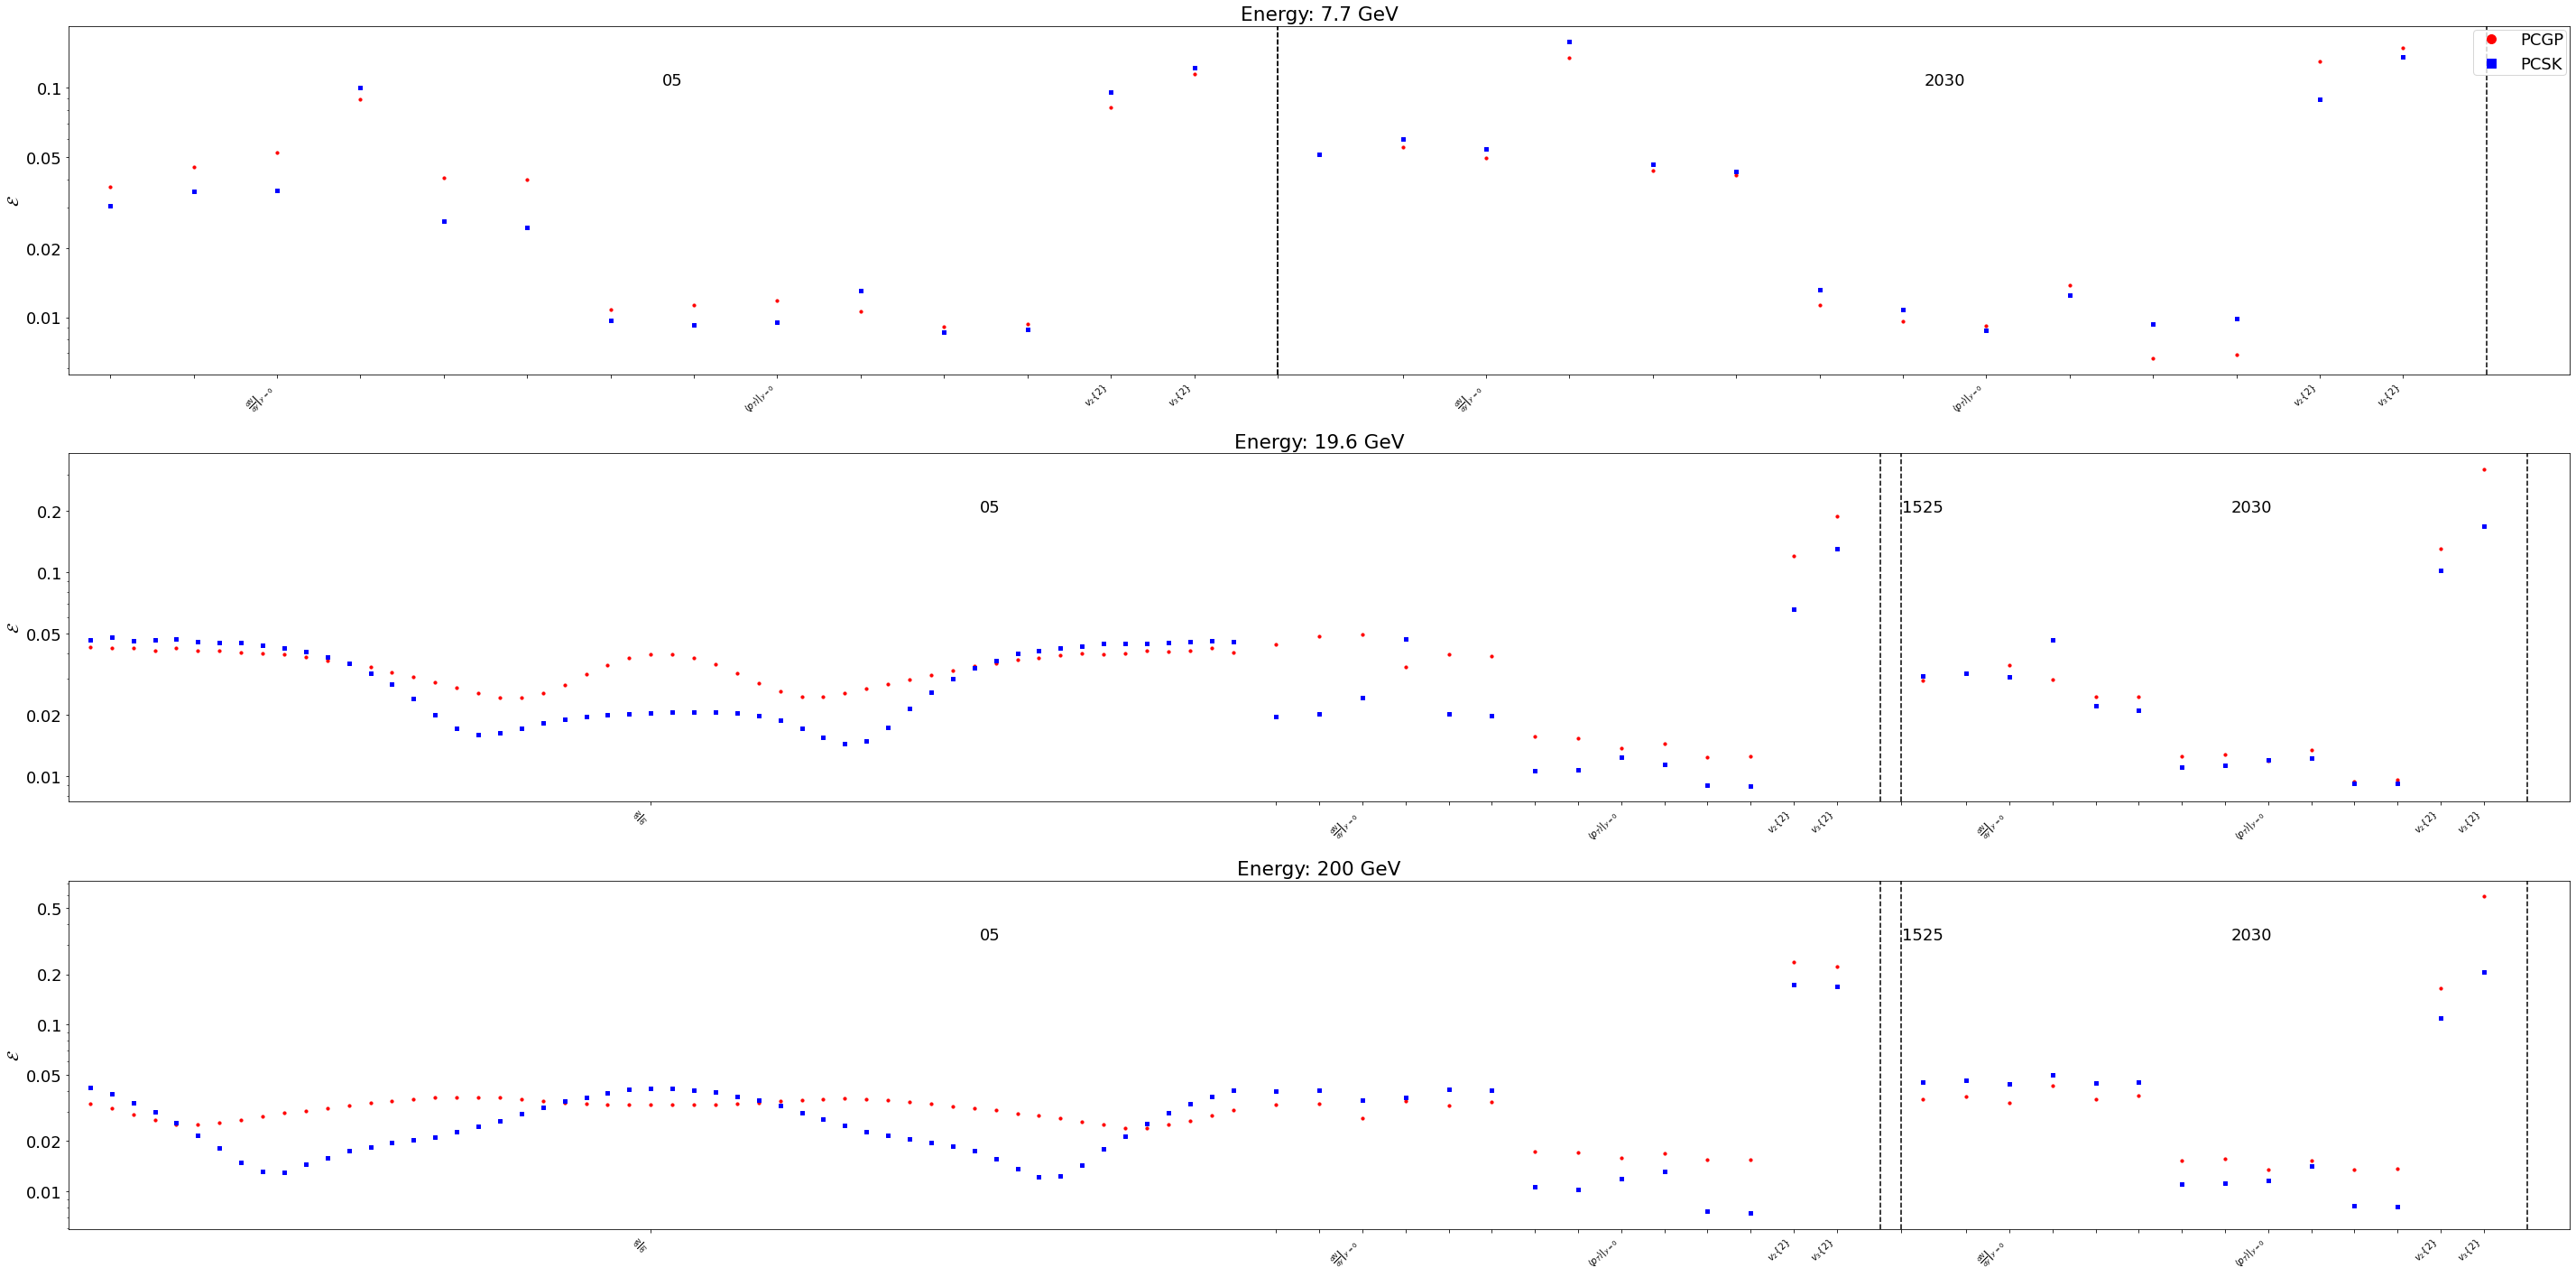

[INFO][_mathtext] Substituting symbol H from STIXNonUnicode


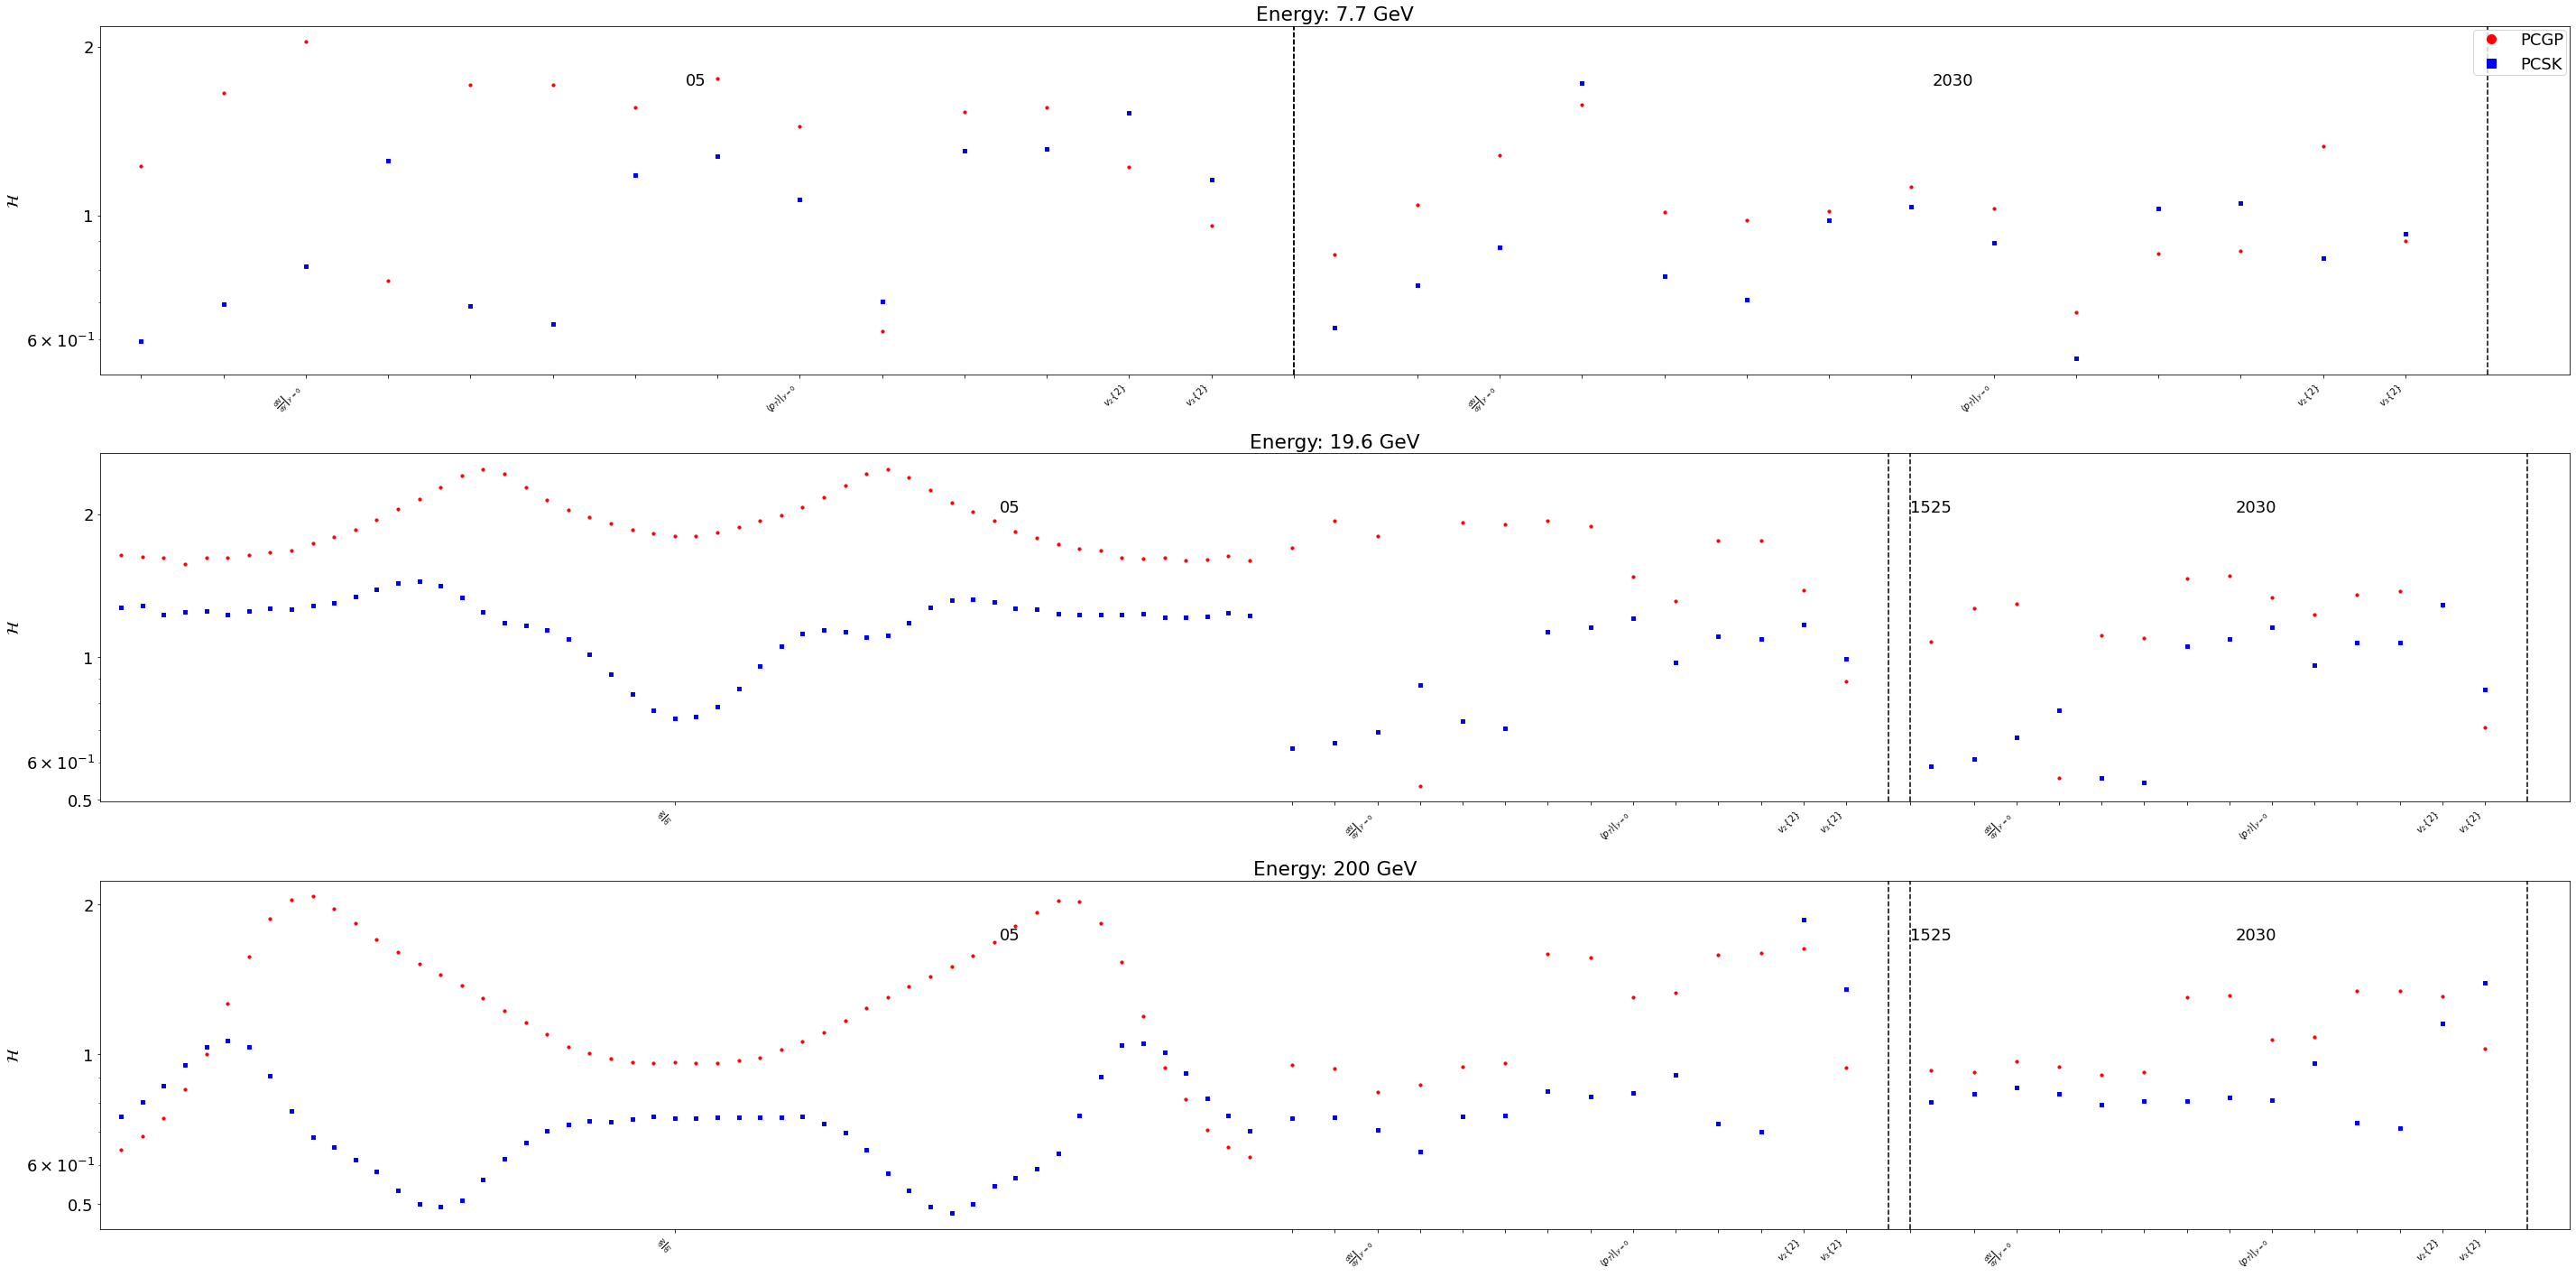

In [44]:
    
#print(filename_prefix_list)
colors = ['r', 'b', 'g', 'magenta', 'teal', 'orange', 'purple', 'grey', 'seagreen']

fig, axs = plt.subplots(3, 1, figsize=(40, 20))
plt.rc('font', size=18)
energies = ['7.7', '19.6', '200']
centralities = ['05', '1525', '2030']
id_max=[-1]
for i, energy in enumerate(energies):
    axs[i].set_title(f'Energy: {energy} GeV')
   
    dataset_boundaries = [0]
    cent_boundaries = [0]
    idx_observable = 0
    midpoint=[]
    cent=[]
    for centrality in centralities:
        
        if centrality in data[energy]:
            cent_boundaries.append(idx_observable)
            for dataset in range(len(data[energy][centrality]["name"])):
                #idx = filename_prefix_list.index(f'exp_{energy}_{centrality}_{data[energy][centrality][dataset]}')
                # if(energy=='200'):
                #     print(data[energy][centrality][dataset])
                #     print(len(err1_list[dataset][-1]))
                #     print("-----")
                #print(data[energy][centrality]["name"][dataset])
                for obs in range(len(data[energy][centrality]["err1"][dataset])):
                    axs[i].scatter(idx_observable, np.abs(data[energy][centrality]["err1"][dataset][obs]), color=colors[0], marker='o', s=10)
                    axs[i].scatter(idx_observable, np.abs(data[energy][centrality]["err2"][dataset][obs]), color=colors[1], marker='s', s=10)
                    idx_observable += 1
                    #print(obs)
                    #print(dataset)
                    #print(data[energy][centrality][dataset])
                    
                idx_observable+=1
                dataset_boundaries.append(idx_observable)
            
            axs[i].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))
            if not (energy=='7.7' and centrality=='05'):
                idx_observable+=1
            #idx_observable+=2
            if not (energy=='7.7' and centrality=='1525'):
                midpoint.append((idx_observable + cent_boundaries[-1]) / 2)
                cent.append(centrality)
            
    id_max.append(idx_observable)
    for k,mid in enumerate(midpoint):
        axs[i].text(mid/idx_observable, 0.82, cent[k], rotation=0, verticalalignment='bottom', horizontalalignment='center',transform=axs[i].transAxes)
        
    
    average_indices = [(start + end) // 2  - 1 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
    #print(average_indices)
    #print(average_indices)
    axs[i].set_xticks(average_indices)
    labels = [convert_to_notation(f'{obs}') for centrality in centralities for obs in data[energy][centrality]["name"]]
    #print(labels)
    #print(labels)
    #print(labels)
    axs[i].set_xticklabels(labels, rotation=45, ha='right', fontsize=10)

    #for boundary, cent in zip(dataset_boundaries[:-1], centralities):
        

legend_elements = [
    plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP', linestyle='None'),
    plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='PCSK', linestyle='None'),
]

axs[0].legend(handles=legend_elements, loc='upper right', borderpad=0.12, borderaxespad=0.25)

for i,ax in enumerate(axs):
    ax.set_xlim([-1, id_max[i+1] + 1])
    ax.set_ylabel(r"$\mathcal{E}$")
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    ax.yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels

plt.tight_layout()
plt.savefig("err_full_training_set_LHCpoints_noPCA.pdf")

# # honesty plot
fig, axs = plt.subplots(3, 1, figsize=(40, 20))
plt.rc('font', size=18)


for i, energy in enumerate(energies):
    axs[i].set_title(f'Energy: {energy} GeV')
   
    dataset_boundaries = [0]
    cent_boundaries = [0]
    idx_observable = 0
    midpoint=[]
    cent=[]
    for centrality in centralities:
        
        if centrality in data[energy]:
            cent_boundaries.append(idx_observable)
            for dataset in range(len(data[energy][centrality]["name"])):
                #idx = filename_prefix_list.index(f'exp_{energy}_{centrality}_{data[energy][centrality][dataset]}')
                # if(energy=='200'):
                #     print(data[energy][centrality][dataset])
                #     print(len(err1_list[dataset][-1]))
                #     print("-----")
                #print(data[energy][centrality]["name"][dataset])
                for obs in range(len(data[energy][centrality]["err1"][dataset])):
                    axs[i].scatter(idx_observable, np.abs(data[energy][centrality]["hon1"][dataset][obs]), color=colors[0], marker='o', s=10)
                    axs[i].scatter(idx_observable, np.abs(data[energy][centrality]["hon2"][dataset][obs]), color=colors[1], marker='s', s=10)
                    idx_observable += 1
                    #print(obs)
                    #print(dataset)
                    #print(data[energy][centrality][dataset])
                    
                idx_observable+=1
                dataset_boundaries.append(idx_observable)
            
            axs[i].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))
            if not (energy=='7.7' and centrality=='05'):
                idx_observable+=1
            #idx_observable+=2
            if not (energy=='7.7' and centrality=='1525'):
                midpoint.append((idx_observable + cent_boundaries[-1]) / 2)
                cent.append(centrality)
            
    id_max.append(idx_observable)
    for k,mid in enumerate(midpoint):
        axs[i].text(mid/idx_observable, 0.82, cent[k], rotation=0, verticalalignment='bottom', horizontalalignment='center',transform=axs[i].transAxes)
    
    average_indices = [(start + end) // 2  - 1 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
    #print(average_indices)
    #print(average_indices)
    axs[i].set_xticks(average_indices)
    labels = [convert_to_notation(f'{obs}') for centrality in centralities for obs in data[energy][centrality]["name"]]
    #print(labels)
    #print(labels)
    #print(labels)
    axs[i].set_xticklabels(labels, rotation=45, ha='right', fontsize=10)

    #for boundary, cent in zip(dataset_boundaries[:-1], centralities):
        

legend_elements = [
    plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP', linestyle='None'),
    plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='PCSK', linestyle='None'),
]

axs[0].legend(handles=legend_elements, loc='upper right', borderpad=0.12, borderaxespad=0.25)

for i,ax in enumerate(axs):
    ax.set_xlim([-1, id_max[i+1] + 1])
    ax.set_ylabel(r"$\mathcal{H}$")
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    ax.yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels

plt.tight_layout()
plt.savefig("hon_full_training_set_LHCpoints_noPCA.pdf")

In [ ]:
###ENDE###

In [ ]:
#model_par contains the full range of values for the parameters
model_par = '../training_points/configs/config_AuAu_200_bulk_scan_central.yaml'
path_input = '../latent_train/'
path_output = '../trained_emulators_no_PCA/'


# Check if the output folder exists, if not, create it
if not os.path.exists(path_output):
    os.makedirs(path_output)

for dataset in datasets_train:
    emu1 = EmulatorBAND(f'{path_input}{dataset}', model_par, method='PCGP', logTrafo=False, parameterTrafoPCA=False)

    emu1.trainEmulatorAutoMask()
    emu2 = EmulatorBAND(f'{path_input}{dataset}', model_par, method='PCSK', logTrafo=False, parameterTrafoPCA=False)
    emu2.trainEmulatorAutoMask()


    with open(f'{path_output}{dataset.split(".p")[0].split("/")[-1]}_PCGP_trained.sav', 'wb') as f:
        dill.dump(emu1, f)
    with open(f'{path_output}{dataset.split(".p")[0].split("/")[-1]}_PCSK_trained.sav', 'wb') as f:
        dill.dump(emu2, f)

[INFO][emulator_BAND] loading training data from ../latent_train/../latent_train/exp_19.6_05_eta_spectra_train.pkl ...
[INFO][emulator_BAND] Not discarding parameters with high errors. To enable this, we have to add cuts!
[1.0569, 0.1302500000000002, 0.6737500000000001, 0.2625, 0.146871, 1.7194, 0.16005, 0.762, 1.334, 0.15436, 0.054200000000000005, 15.7865, 0.036065, 0.10282, 1.1692]
[1.1535, -0.1997500000000001, -1.13075, 0.3315, 0.12332900000000001, 2.7910000000000004, 0.23204999999999995, 1.1300000000000001, 0.354, 0.16732, 0.0606, 39.2495, 0.06988500000000002, 0.11961999999999999, 0.93]
[1.3256999999999999, 1.4722499999999998, 0.48475, 0.5755, 0.074755, 0.4958, 0.28425, 0.534, 2.0300000000000002, 0.2494, 0.18860000000000002, 9.1505, 0.08356500000000001, 0.09133999999999998, 1.0108]
[INFO][emulator_BAND] All training data are loaded.
[INFO][emulator_BAND] Training dataset size: 3, discarded points: 0
[INFO][emulator_BAND] Performing emulator training ...
[INFO][emulator_BAND] Train 

BELOW THIS, I HAVE NOT ADAPTED ANYTHING YET

In [26]:
filename_prefix_list = ["7p7_dNdy_emu_out","19p6_dNdy_emu_out","200_dNdy_emu_out","19p6PHOBOS_dNdeta_emu_out","200PHOBOS_dNdeta_emu_out"]
filename_prefix_list_LOG = ["7p7_LOGdNdy_emu_out","19p6_LOGdNdy_emu_out","200_LOGdNdy_emu_out","19p6PHOBOS_LOGdNdeta_emu_out","200PHOBOS_LOGdNdeta_emu_out"]
foldername = 'emulator_outputs_only_LHC/emulator_output'

emulator = 0

err1_list = []
err2_list = []
err3_list = []
hon1_list = []
hon2_list = []
hon3_list = []
for file in filename_prefix_list:
    err, hon = read_multiple_emulator_errors_files([30],foldername,file)
    err1_list.append(err[0])
    err2_list.append(err[1])
    err3_list.append(err[2])
    hon1_list.append(hon[0])
    hon2_list.append(hon[1])
    hon3_list.append(hon[2])

err1_list_PCA = []
err2_list_PCA = []
err3_list_PCA = []
hon1_list_PCA = []
hon2_list_PCA = []
hon3_list_PCA = []
for file in filename_prefix_list_LOG:
    err, hon = read_multiple_emulator_errors_files([30],foldername,file)
    err1_list_PCA.append(err[0])
    err2_list_PCA.append(err[1])
    err3_list_PCA.append(err[2])
    hon1_list_PCA.append(hon[0])
    hon2_list_PCA.append(hon[1])
    hon3_list_PCA.append(hon[2])

light_red = (1.0, 0.6, 0.6)  # Light red
light_blue = (0.6, 0.6, 1.0)  # Light blue
light_green = (0.6, 0.9, 0.6)  # Light green
colors = ['r','b','g',light_red,light_blue,light_green]
labels = [r'${\rm d}N/{\rm d}y|^{7.7\;\mathrm{GeV}}_{\pi^+,K^+,p}$',
          r'${\rm d}N/{\rm d}y|^{19.6\;\mathrm{GeV}}_{\pi^+,K^+,p}$',
          r'${\rm d}N/{\rm d}y|^{200\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$',
          r'${\rm d}N_{\rm ch}/{\rm d}\eta|^{19.6\;\mathrm{GeV}}$',
          r'${\rm d}N_{\rm ch}/{\rm d}\eta|^{200\;\mathrm{GeV}}$',
          ]

fig, axs = plt.subplots(2, 1, figsize=(12, 6))
plt.rc('font', size=18)
idx_dataset = 0
idx_observable = 0
dataset_boundaries = [0]
for dataset in range(len(err1_list[:3])):  # Only iterate over the first 5 data sets
    for obs in range(len(err1_list[dataset][-1])):
        if emulator == 0:
            axs[0].scatter(idx_observable, err1_list[dataset][-1][obs], color=colors[0], marker='o', s=10)
            axs[0].scatter(idx_observable, err1_list_PCA[dataset][-1][obs], color=colors[3], marker='o', s=10, facecolors='None')
        elif emulator == 1:
            axs[0].scatter(idx_observable, err2_list[dataset][-1][obs], color=colors[1], marker='s', s=10)
            axs[0].scatter(idx_observable, err2_list_PCA[dataset][-1][obs], color=colors[4], marker='s', s=10, facecolors='None')
        elif emulator == 2:
            axs[0].scatter(idx_observable, err3_list[dataset][-1][obs], color=colors[2], marker='^', s=10)
            axs[0].scatter(idx_observable, err3_list_PCA[dataset][-1][obs], color=colors[5], marker='^', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(err1_list[:3]):
        axs[0].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))  

# Plot for the bottom part
idx_dataset = 0
idx_observable = 0
dataset_boundaries1 = [0]
for dataset in range(3, len(err1_list)):  # Iterate over the remaining data sets
    for obs in range(len(err1_list[dataset][-1])):
        if emulator == 0:
            axs[1].scatter(idx_observable, err1_list[dataset][-1][obs], color=colors[0], marker='o', s=10)
            axs[1].scatter(idx_observable, err1_list_PCA[dataset][-1][obs], color=colors[3], marker='o', s=10, facecolors='None')
        elif emulator == 1:
            axs[1].scatter(idx_observable, err2_list[dataset][-1][obs], color=colors[1], marker='s', s=10)
            axs[1].scatter(idx_observable, err2_list_PCA[dataset][-1][obs], color=colors[4], marker='s', s=10, facecolors='None')
        elif emulator == 2:
            axs[1].scatter(idx_observable, err3_list[dataset][-1][obs], color=colors[2], marker='^', s=10)
            axs[1].scatter(idx_observable, err3_list_PCA[dataset][-1][obs], color=colors[5], marker='^', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries1.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(err1_list[3:]):
        axs[1].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))

# Compute the average index for each dataset
average_indices1 = [(start + end) // 2 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
average_indices2 = [(start + end) // 2 for start, end in zip(dataset_boundaries1[:-1], dataset_boundaries1[1:])]

# Set the x-labels at the average indices
axs[0].set_xticks(average_indices1)
axs[1].set_xticks(average_indices2)
axs[0].set_xticklabels(labels[:3], rotation=0, ha='center', fontsize=15)
axs[1].set_xticklabels(labels[3:], rotation=0, ha='center', fontsize=15)

if emulator == 0:
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP', linestyle='None'),
        plt.Line2D([0], [0], marker='o', color=colors[3], markersize=10, label='PCGP log', linestyle='None', fillstyle='none')
    ]
elif emulator == 1:
    legend_elements = [
        plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='PCSK', linestyle='None'),
        plt.Line2D([0], [0], marker='s', color=colors[4], markersize=10, label='PCSK log', linestyle='None', fillstyle='none')
    ]
elif emulator == 2:
    legend_elements = [
        plt.Line2D([0], [0], marker='^', color=colors[2], markersize=10, label='Scikit GP', linestyle='None'),
        plt.Line2D([0], [0], marker='^', color=colors[5], markersize=10, label='Scikit GP log', linestyle='None', fillstyle='none')
    ]
axs[0].legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.12, borderaxespad=0.25)
axs[0].set_xlim([-1, dataset_boundaries[-1] + 1])
axs[1].set_xlim([-1, dataset_boundaries1[-1] + 1])
axs[0].set_ylabel(r"$\mathcal{E}$")
axs[1].set_ylabel(r"$\mathcal{E}$")
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
axs[0].yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
axs[1].yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels
plt.tight_layout()
if emulator == 0:
    plt.savefig("err_full_training_set_LOG_PCGP_noPCA.pdf")
elif emulator == 1:
    plt.savefig("err_full_training_set_LOG_PCSK_noPCA.pdf")
elif emulator == 2:
    plt.savefig("err_full_training_set_LOG_Scikit_noPCA.pdf")

# honesty plot
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
plt.rc('font', size=18)
idx_dataset = 0
idx_observable = 0
dataset_boundaries = [0]
for dataset in range(len(hon1_list[:3])):  # Only iterate over the first 5 data sets
    for obs in range(len(hon1_list[dataset][-1])):
        if emulator == 0:
            axs[0].scatter(idx_observable, np.log(hon1_list[dataset][-1][obs]), color=colors[0], marker='o', s=10)
            axs[0].scatter(idx_observable, np.log(hon1_list_PCA[dataset][-1][obs]), color=colors[3], marker='o', s=10, facecolors='None')
        elif emulator == 1:
            axs[0].scatter(idx_observable, np.log(hon2_list[dataset][-1][obs]), color=colors[1], marker='s', s=10)
            axs[0].scatter(idx_observable, np.log(hon2_list_PCA[dataset][-1][obs]), color=colors[4], marker='s', s=10, facecolors='None')
        elif emulator == 2:
            axs[0].scatter(idx_observable, np.log(hon3_list[dataset][-1][obs]), color=colors[2], marker='^', s=10)
            axs[0].scatter(idx_observable, np.log(hon3_list_PCA[dataset][-1][obs]), color=colors[5], marker='^', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(hon1_list[:3]):
        axs[0].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))  

# Plot for the bottom part
idx_dataset = 0
idx_observable = 0
dataset_boundaries1 = [0]
for dataset in range(3, len(hon1_list)):  # Iterate over the remaining data sets
    for obs in range(len(hon1_list[dataset][-1])):
        if emulator == 0:
            axs[1].scatter(idx_observable, np.log(hon1_list[dataset][-1][obs]), color=colors[0], marker='o', s=10)
            axs[1].scatter(idx_observable, np.log(hon1_list_PCA[dataset][-1][obs]), color=colors[3], marker='o', s=10, facecolors='None')
        elif emulator == 1:
            axs[1].scatter(idx_observable, np.log(hon2_list[dataset][-1][obs]), color=colors[1], marker='s', s=10)
            axs[1].scatter(idx_observable, np.log(hon2_list_PCA[dataset][-1][obs]), color=colors[4], marker='s', s=10, facecolors='None')
        elif emulator == 2:
            axs[1].scatter(idx_observable, np.log(hon3_list[dataset][-1][obs]), color=colors[2], marker='^', s=10)
            axs[1].scatter(idx_observable, np.log(hon3_list_PCA[dataset][-1][obs]), color=colors[5], marker='^', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries1.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(hon1_list[3:]):
        axs[1].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))

# Compute the average index for each dataset
average_indices1 = [(start + end) // 2 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
average_indices2 = [(start + end) // 2 for start, end in zip(dataset_boundaries1[:-1], dataset_boundaries1[1:])]

# Set the x-labels at the average indices
axs[0].set_xticks(average_indices1)
axs[1].set_xticks(average_indices2)
axs[0].set_xticklabels(labels[:3], rotation=0, ha='center', fontsize=15)
axs[1].set_xticklabels(labels[3:], rotation=0, ha='center', fontsize=15)

if emulator == 0:
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP', linestyle='None'),
        plt.Line2D([0], [0], marker='o', color=colors[3], markersize=10, label='PCGP log', linestyle='None', fillstyle='none')
    ]
elif emulator == 1:
    legend_elements = [
        plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='PCSK', linestyle='None'),
        plt.Line2D([0], [0], marker='s', color=colors[4], markersize=10, label='PCSK log', linestyle='None', fillstyle='none')
    ]
elif emulator == 2:
    legend_elements = [
        plt.Line2D([0], [0], marker='^', color=colors[2], markersize=10, label='Scikit GP', linestyle='None'),
        plt.Line2D([0], [0], marker='^', color=colors[5], markersize=10, label='Scikit GP log', linestyle='None', fillstyle='none')
    ]
axs[0].legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.12, borderaxespad=0.25)
axs[0].set_xlim([-1, dataset_boundaries[-1] + 1])
axs[1].set_xlim([-1, dataset_boundaries1[-1] + 1])
axs[0].set_ylabel(r"$\mathcal{H}$")
axs[1].set_ylabel(r"$\mathcal{H}$")
axs[0].set_ylim([-1, 1])
axs[1].set_ylim([-1, 1])
axs[0].axhline(y=0, color='k', linestyle=':', zorder=(-10))
axs[1].axhline(y=0, color='k', linestyle=':', zorder=(-10))
plt.tight_layout()
if emulator == 0:
    plt.savefig("hon_full_training_set_LOG_PCGP_noPCA.pdf")
elif emulator == 1:
    plt.savefig("hon_full_training_set_LOG_PCSK_noPCA.pdf")
elif emulator == 2:
    plt.savefig("hon_full_training_set_LOG_Scikit_noPCA.pdf")


FileNotFoundError: [Errno 2] No such file or directory: 'emulator_outputs_only_LHC/emulator_output/7p7_dNdy_emu_out_30_pred_err_obs_1.dat'

Compare the emulators with and without the posterior points.

In [ ]:
# filename_prefix_list = ["7p7_dNdy_emu_out","7p7_pTvn_emu_out","19p6_dNdy_emu_out","19p6_pTvn_emu_out","200_dNdy_emu_out","200_pTvn_emu_out","19p6PHOBOS_dNdeta_emu_out","200PHOBOS_dNdeta_emu_out","200PHOBOS_vn_emu_out"]
# foldername = 'emulator_outputs_with_posterior/emulator_output'
# foldername1 = 'emulator_outputs_with_posterior/emulator_output'

# emulator = 0

# err1_list = []
# err2_list = []
# err3_list = []
# hon1_list = []
# hon2_list = []
# hon3_list = []
# for file in filename_prefix_list:
#     err, hon = read_multiple_emulator_errors_files([100],foldername,file)
#     err1_list.append(err[0])
#     err2_list.append(err[1])
#     err3_list.append(err[2])
#     hon1_list.append(hon[0])
#     hon2_list.append(hon[1])
#     hon3_list.append(hon[2])

# err1_list_PCA = []
# err2_list_PCA = []
# err3_list_PCA = []
# hon1_list_PCA = []
# hon2_list_PCA = []
# hon3_list_PCA = []
# for file in filename_prefix_list:
#     err, hon = read_multiple_emulator_errors_files([30],foldername1,file)
#     err1_list_PCA.append(err[0])
#     err2_list_PCA.append(err[1])
#     err3_list_PCA.append(err[2])
#     hon1_list_PCA.append(hon[0])
#     hon2_list_PCA.append(hon[1])
#     hon3_list_PCA.append(hon[2])

# light_red = (1.0, 0.6, 0.6)  # Light red
# light_blue = (0.6, 0.6, 1.0)  # Light blue
# light_green = (0.6, 0.9, 0.6)  # Light green
# colors = ['r','b','g',light_red,light_blue,light_green]
# labels = [r'${\rm d}N/{\rm d}y|^{7.7\;\mathrm{GeV}}_{\pi^+,K^+,p}$',
#           r'$\langle p_{\rm T}\rangle|^{7.7\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$' + '\\\n' + r'$v_{2/3}^{\rm ch}\lbrace 2\rbrace|^{7.7\;\mathrm{GeV}}$',
#           r'${\rm d}N/{\rm d}y|^{19.6\;\mathrm{GeV}}_{\pi^+,K^+,p}$',
#           r'$\langle p_{\rm T}\rangle|^{19.6\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$' + '\\\n' + r'$v_{2/3}^{\rm ch}\lbrace 2\rbrace|^{19.6\;\mathrm{GeV}}$',
#           r'${\rm d}N/{\rm d}y|^{200\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$',
#           r'$\langle p_{\rm T}\rangle|^{200\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$' + '\\\n' + r'$v_{2/3}^{\rm ch}\lbrace 2\rbrace|^{200\;\mathrm{GeV}}$',
#           r'${\rm d}N_{\rm ch}/{\rm d}\eta|^{19.6\;\mathrm{GeV}}$',
#           r'${\rm d}N_{\rm ch}/{\rm d}\eta|^{200\;\mathrm{GeV}}$',
#           r'$v_2^{\rm ch}(\eta)|^{200\;\mathrm{GeV}}$'
#           ]

# fig, axs = plt.subplots(2, 1, figsize=(12, 6))
# plt.rc('font', size=18)
# idx_dataset = 0
# idx_observable = 0
# dataset_boundaries = [0]
# for dataset in range(len(err1_list[:6])):  # Only iterate over the first 5 data sets
#     for obs in range(len(err1_list[dataset][-1])):
#         if emulator == 0:
#             axs[0].scatter(idx_observable, err1_list[dataset][-1][obs], color=colors[0], marker='o', s=10)
#             axs[0].scatter(idx_observable, err1_list_PCA[dataset][-1][obs], color=colors[3], marker='o', s=10, facecolors='None')
#         elif emulator == 1:
#             axs[0].scatter(idx_observable, err2_list[dataset][-1][obs], color=colors[1], marker='s', s=10)
#             axs[0].scatter(idx_observable, err2_list_PCA[dataset][-1][obs], color=colors[4], marker='s', s=10, facecolors='None')
#         elif emulator == 2:
#             axs[0].scatter(idx_observable, err3_list[dataset][-1][obs], color=colors[2], marker='^', s=10)
#             axs[0].scatter(idx_observable, err3_list_PCA[dataset][-1][obs], color=colors[5], marker='^', s=10, facecolors='None')
#         idx_observable += 1

#     dataset_boundaries.append(idx_observable)
#     idx_dataset += 1
#     if idx_dataset < len(err1_list[:6]):
#         axs[0].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))  

# # Plot for the bottom part
# idx_dataset = 0
# idx_observable = 0
# dataset_boundaries1 = [0]
# for dataset in range(6, len(err1_list)):  # Iterate over the remaining data sets
#     for obs in range(len(err1_list[dataset][-1])):
#         if emulator == 0:
#             axs[1].scatter(idx_observable, err1_list[dataset][-1][obs], color=colors[0], marker='o', s=10)
#             axs[1].scatter(idx_observable, err1_list_PCA[dataset][-1][obs], color=colors[3], marker='o', s=10, facecolors='None')
#         elif emulator == 1:
#             axs[1].scatter(idx_observable, err2_list[dataset][-1][obs], color=colors[1], marker='s', s=10)
#             axs[1].scatter(idx_observable, err2_list_PCA[dataset][-1][obs], color=colors[4], marker='s', s=10, facecolors='None')
#         elif emulator == 2:
#             axs[1].scatter(idx_observable, err3_list[dataset][-1][obs], color=colors[2], marker='^', s=10)
#             axs[1].scatter(idx_observable, err3_list_PCA[dataset][-1][obs], color=colors[5], marker='^', s=10, facecolors='None')
#         idx_observable += 1

#     dataset_boundaries1.append(idx_observable)
#     idx_dataset += 1
#     if idx_dataset < len(err1_list[6:]):
#         axs[1].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))

# # Compute the average index for each dataset
# average_indices1 = [(start + end) // 2 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
# average_indices2 = [(start + end) // 2 for start, end in zip(dataset_boundaries1[:-1], dataset_boundaries1[1:])]

# # Set the x-labels at the average indices
# axs[0].set_xticks(average_indices1)
# axs[1].set_xticks(average_indices2)
# axs[0].set_xticklabels(labels[:6], rotation=0, ha='center', fontsize=15)
# axs[1].set_xticklabels(labels[6:], rotation=0, ha='center', fontsize=15)

# if emulator == 0:
#     legend_elements = [
#         plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP LHD', linestyle='None'),
#         plt.Line2D([0], [0], marker='o', color=colors[3], markersize=10, label='PCGP LHD + HPP', linestyle='None', fillstyle='none')
#     ]
# elif emulator == 1:
#     legend_elements = [
#         plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='PCSK LHD', linestyle='None'),
#         plt.Line2D([0], [0], marker='s', color=colors[4], markersize=10, label='PCSK LHD + HPP', linestyle='None', fillstyle='none')
#     ]
# elif emulator == 2:
#     legend_elements = [
#         plt.Line2D([0], [0], marker='^', color=colors[2], markersize=10, label='Scikit GP LHD', linestyle='None'),
#         plt.Line2D([0], [0], marker='^', color=colors[5], markersize=10, label='Scikit GP LHD + HPP', linestyle='None', fillstyle='none')
#     ]
# axs[0].legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.12, borderaxespad=0.25)
# axs[0].set_xlim([-1, dataset_boundaries[-1] + 1])
# axs[1].set_xlim([-1, dataset_boundaries1[-1] + 1])
# axs[0].set_ylabel(r"$\mathcal{E}$")
# axs[1].set_ylabel(r"$\mathcal{E}$")
# axs[0].set_yscale('log')
# axs[1].set_yscale('log')
# axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
# axs[0].yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels
# axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
# axs[1].yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels
# plt.tight_layout()
# if emulator == 0:
#     plt.savefig("err_LHC_vs_POST_PCGP_noPCA.pdf")
# elif emulator == 1:
#     plt.savefig("err_LHC_vs_POST_PCSK_noPCA.pdf")
# elif emulator == 2:
#     plt.savefig("err_LHC_vs_POST_Scikit_noPCA.pdf")

# # honesty plot
# fig, axs = plt.subplots(2, 1, figsize=(12, 6))
# plt.rc('font', size=18)
# idx_dataset = 0
# idx_observable = 0
# dataset_boundaries = [0]
# for dataset in range(len(hon1_list[:6])):  # Only iterate over the first 5 data sets
#     for obs in range(len(hon1_list[dataset][-1])):
#         if emulator == 0:
#             axs[0].scatter(idx_observable, np.log(hon1_list[dataset][-1][obs]), color=colors[0], marker='o', s=10)
#             axs[0].scatter(idx_observable, np.log(hon1_list_PCA[dataset][-1][obs]), color=colors[3], marker='o', s=10, facecolors='None')
#         elif emulator == 1:
#             axs[0].scatter(idx_observable, np.log(hon2_list[dataset][-1][obs]), color=colors[1], marker='s', s=10)
#             axs[0].scatter(idx_observable, np.log(hon2_list_PCA[dataset][-1][obs]), color=colors[4], marker='s', s=10, facecolors='None')
#         elif emulator == 2:
#             axs[0].scatter(idx_observable, np.log(hon3_list[dataset][-1][obs]), color=colors[2], marker='^', s=10)
#             axs[0].scatter(idx_observable, np.log(hon3_list_PCA[dataset][-1][obs]), color=colors[5], marker='^', s=10, facecolors='None')
#         idx_observable += 1

#     dataset_boundaries.append(idx_observable)
#     idx_dataset += 1
#     if idx_dataset < len(hon1_list[:6]):
#         axs[0].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))  

# # Plot for the bottom part
# idx_dataset = 0
# idx_observable = 0
# dataset_boundaries1 = [0]
# for dataset in range(6, len(hon1_list)):  # Iterate over the remaining data sets
#     for obs in range(len(hon1_list[dataset][-1])):
#         if emulator == 0:
#             axs[1].scatter(idx_observable, np.log(hon1_list[dataset][-1][obs]), color=colors[0], marker='o', s=10)
#             axs[1].scatter(idx_observable, np.log(hon1_list_PCA[dataset][-1][obs]), color=colors[3], marker='o', s=10, facecolors='None')
#         elif emulator == 1:
#             axs[1].scatter(idx_observable, np.log(hon2_list[dataset][-1][obs]), color=colors[1], marker='s', s=10)
#             axs[1].scatter(idx_observable, np.log(hon2_list_PCA[dataset][-1][obs]), color=colors[4], marker='s', s=10, facecolors='None')
#         elif emulator == 2:
#             axs[1].scatter(idx_observable, np.log(hon3_list[dataset][-1][obs]), color=colors[2], marker='^', s=10)
#             axs[1].scatter(idx_observable, np.log(hon3_list_PCA[dataset][-1][obs]), color=colors[5], marker='^', s=10, facecolors='None')
#         idx_observable += 1

#     dataset_boundaries1.append(idx_observable)
#     idx_dataset += 1
#     if idx_dataset < len(hon1_list[6:]):
#         axs[1].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))

# # Compute the average index for each dataset
# average_indices1 = [(start + end) // 2 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
# average_indices2 = [(start + end) // 2 for start, end in zip(dataset_boundaries1[:-1], dataset_boundaries1[1:])]

# # Set the x-labels at the average indices
# axs[0].set_xticks(average_indices1)
# axs[1].set_xticks(average_indices2)
# axs[0].set_xticklabels(labels[:6], rotation=0, ha='center', fontsize=15)
# axs[1].set_xticklabels(labels[6:], rotation=0, ha='center', fontsize=15)

# if emulator == 0:
#     legend_elements = [
#         plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP LHD', linestyle='None'),
#         plt.Line2D([0], [0], marker='o', color=colors[3], markersize=10, label='PCGP LHD + HPP', linestyle='None', fillstyle='none')
#     ]
# elif emulator == 1:
#     legend_elements = [
#         plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='PCSK LHD', linestyle='None'),
#         plt.Line2D([0], [0], marker='s', color=colors[4], markersize=10, label='PCSK LHD + HPP', linestyle='None', fillstyle='none')
#     ]
# elif emulator == 2:
#     legend_elements = [
#         plt.Line2D([0], [0], marker='^', color=colors[2], markersize=10, label='Scikit GP LHD', linestyle='None'),
#         plt.Line2D([0], [0], marker='^', color=colors[5], markersize=10, label='Scikit GP LHD + HPP', linestyle='None', fillstyle='none')
#     ]
# axs[0].legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.12, borderaxespad=0.25)
# axs[0].set_xlim([-1, dataset_boundaries[-1] + 1])
# axs[1].set_xlim([-1, dataset_boundaries1[-1] + 1])
# axs[0].set_ylabel(r"$\mathcal{H}$")
# axs[1].set_ylabel(r"$\mathcal{H}$")
# axs[0].set_ylim([-2.5, 2.5])
# axs[1].set_ylim([-2.5, 2.5])
# axs[0].axhline(y=0, color='k', linestyle=':', zorder=(-10))
# axs[1].axhline(y=0, color='k', linestyle=':', zorder=(-10))
# plt.tight_layout()
# if emulator == 0:
#     plt.savefig("hon_LHC_vs_POST_PCGP_noPCA.pdf")
# elif emulator == 1:
#     plt.savefig("hon_LHC_vs_POST_PCSK_noPCA.pdf")
# elif emulator == 2:
#     plt.savefig("hon_LHC_vs_POST_Scikit_noPCA.pdf")


Compute the average $\mathcal{E}$ and $\mathcal{H}$ for the emulators:

In [ ]:
filename_prefix_list = ["7p7_dNdy_emu_out","7p7_pTvn_emu_out","19p6_dNdy_emu_out","19p6_pTvn_emu_out","200_dNdy_emu_out","200_pTvn_emu_out","19p6PHOBOS_dNdeta_emu_out","200PHOBOS_dNdeta_emu_out","200PHOBOS_vn_emu_out"]
foldername = 'emulator_outputs_with_posterior/emulator_output'

emulator = 2

err1_list = []
err2_list = []
err3_list = []
hon1_list = []
hon2_list = []
hon3_list = []
for file in filename_prefix_list:
    err, hon = read_multiple_emulator_errors_files([30],foldername,file)
    err1_list.append(err[0])
    err2_list.append(err[1])
    err3_list.append(err[2])
    hon1_list.append(hon[0])
    hon2_list.append(hon[1])
    hon3_list.append(hon[2])

PCGP_E = 0.
PCSK_E = 0.
SCIKIT_E = 0.

PCGP_H = 0.
PCSK_H = 0.
SCIKIT_H = 0.

num_obs = 0
for dataset in range(len(err1_list[:6])):  # Only iterate over the first 5 data sets
    for obs in range(len(err1_list[dataset][-1])):
        num_obs += 1
        if emulator == 0:
            PCGP_E += err1_list[dataset][-1][obs]
            PCGP_H += np.log(hon1_list[dataset][-1][obs])
        elif emulator == 1:
            PCSK_E += err2_list[dataset][-1][obs]
            PCSK_H += np.log(hon2_list[dataset][-1][obs])
        elif emulator == 2:
            SCIKIT_E += err3_list[dataset][-1][obs]
            SCIKIT_H += np.log(hon3_list[dataset][-1][obs])

PCGP_E /= num_obs
PCSK_E /= num_obs
SCIKIT_E /= num_obs
PCGP_H /= num_obs
PCSK_H /= num_obs
SCIKIT_H /= num_obs

if emulator == 0:
    print("PCGP E: ", PCGP_E)
    print("PCGP H: ", PCGP_H)
elif emulator == 1:
    print("PCSK E: ", PCSK_E)
    print("PCSK H: ", PCSK_H)
elif emulator == 2:
    print("Scikit E: ", SCIKIT_E)
    print("Scikit H: ", SCIKIT_H)

Compare the emulators with LHC points with and without PCA.

In [ ]:
filename_prefix_list = ["7p7_dNdy_emu_out","7p7_pTvn_emu_out","19p6_dNdy_emu_out","19p6_pTvn_emu_out","200_dNdy_emu_out","200_pTvn_emu_out","19p6PHOBOS_dNdeta_emu_out","200PHOBOS_dNdeta_emu_out","200PHOBOS_vn_emu_out"]
foldername = 'emulator_outputs_only_LHC/emulator_output'
foldername1 = 'emulator_outputs_only_LHC/emulator_output_PCA'

emulator = 2

err1_list = []
err2_list = []
err3_list = []
hon1_list = []
hon2_list = []
hon3_list = []
for file in filename_prefix_list:
    err, hon = read_multiple_emulator_errors_files([30],foldername,file)
    err1_list.append(err[0])
    err2_list.append(err[1])
    err3_list.append(err[2])
    hon1_list.append(hon[0])
    hon2_list.append(hon[1])
    hon3_list.append(hon[2])

err1_list_PCA = []
err2_list_PCA = []
err3_list_PCA = []
hon1_list_PCA = []
hon2_list_PCA = []
hon3_list_PCA = []
for file in filename_prefix_list:
    err, hon = read_multiple_emulator_errors_files([30],foldername1,file)
    err1_list_PCA.append(err[0])
    err2_list_PCA.append(err[1])
    err3_list_PCA.append(err[2])
    hon1_list_PCA.append(hon[0])
    hon2_list_PCA.append(hon[1])
    hon3_list_PCA.append(hon[2])

light_red = (1.0, 0.6, 0.6)  # Light red
light_blue = (0.6, 0.6, 1.0)  # Light blue
light_green = (0.6, 0.9, 0.6)  # Light green
colors = ['r','b','g',light_red,light_blue,light_green]
labels = [r'${\rm d}N/{\rm d}y|^{7.7\;\mathrm{GeV}}_{\pi^+,K^+,p}$',
          r'$\langle p_{\rm T}\rangle|^{7.7\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$' + '\\\n' + r'$v_{2/3}^{\rm ch}\lbrace 2\rbrace|^{7.7\;\mathrm{GeV}}$',
          r'${\rm d}N/{\rm d}y|^{19.6\;\mathrm{GeV}}_{\pi^+,K^+,p}$',
          r'$\langle p_{\rm T}\rangle|^{19.6\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$' + '\\\n' + r'$v_{2/3}^{\rm ch}\lbrace 2\rbrace|^{19.6\;\mathrm{GeV}}$',
          r'${\rm d}N/{\rm d}y|^{200\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$',
          r'$\langle p_{\rm T}\rangle|^{200\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$' + '\\\n' + r'$v_{2/3}^{\rm ch}\lbrace 2\rbrace|^{200\;\mathrm{GeV}}$',
          r'${\rm d}N_{\rm ch}/{\rm d}\eta|^{19.6\;\mathrm{GeV}}$',
          r'${\rm d}N_{\rm ch}/{\rm d}\eta|^{200\;\mathrm{GeV}}$',
          r'$v_2^{\rm ch}(\eta)|^{200\;\mathrm{GeV}}$'
          ]

fig, axs = plt.subplots(2, 1, figsize=(12, 6))
plt.rc('font', size=18)
idx_dataset = 0
idx_observable = 0
dataset_boundaries = [0]
for dataset in range(len(err1_list[:6])):  # Only iterate over the first 5 data sets
    for obs in range(len(err1_list[dataset][-1])):
        if emulator == 0:
            axs[0].scatter(idx_observable, err1_list[dataset][-1][obs], color=colors[0], marker='o', s=10)
            axs[0].scatter(idx_observable, err1_list_PCA[dataset][-1][obs], color=colors[3], marker='o', s=10, facecolors='None')
        elif emulator == 1:
            axs[0].scatter(idx_observable, err2_list[dataset][-1][obs], color=colors[1], marker='s', s=10)
            axs[0].scatter(idx_observable, err2_list_PCA[dataset][-1][obs], color=colors[4], marker='s', s=10, facecolors='None')
        elif emulator == 2:
            axs[0].scatter(idx_observable, err3_list[dataset][-1][obs], color=colors[2], marker='^', s=10)
            axs[0].scatter(idx_observable, err3_list_PCA[dataset][-1][obs], color=colors[5], marker='^', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(err1_list[:6]):
        axs[0].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))  

# Plot for the bottom part
idx_dataset = 0
idx_observable = 0
dataset_boundaries1 = [0]
for dataset in range(6, len(err1_list)):  # Iterate over the remaining data sets
    for obs in range(len(err1_list[dataset][-1])):
        if emulator == 0:
            axs[1].scatter(idx_observable, err1_list[dataset][-1][obs], color=colors[0], marker='o', s=10)
            axs[1].scatter(idx_observable, err1_list_PCA[dataset][-1][obs], color=colors[3], marker='o', s=10, facecolors='None')
        elif emulator == 1:
            axs[1].scatter(idx_observable, err2_list[dataset][-1][obs], color=colors[1], marker='s', s=10)
            axs[1].scatter(idx_observable, err2_list_PCA[dataset][-1][obs], color=colors[4], marker='s', s=10, facecolors='None')
        elif emulator == 2:
            axs[1].scatter(idx_observable, err3_list[dataset][-1][obs], color=colors[2], marker='^', s=10)
            axs[1].scatter(idx_observable, err3_list_PCA[dataset][-1][obs], color=colors[5], marker='^', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries1.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(err1_list[6:]):
        axs[1].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))

# Compute the average index for each dataset
average_indices1 = [(start + end) // 2 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
average_indices2 = [(start + end) // 2 for start, end in zip(dataset_boundaries1[:-1], dataset_boundaries1[1:])]

# Set the x-labels at the average indices
axs[0].set_xticks(average_indices1)
axs[1].set_xticks(average_indices2)
axs[0].set_xticklabels(labels[:6], rotation=0, ha='center', fontsize=15)
axs[1].set_xticklabels(labels[6:], rotation=0, ha='center', fontsize=15)

if emulator == 0:
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP', linestyle='None'),
        plt.Line2D([0], [0], marker='o', color=colors[3], markersize=10, label='PCGP PCA', linestyle='None', fillstyle='none')
    ]
elif emulator == 1:
    legend_elements = [
        plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='PCSK', linestyle='None'),
        plt.Line2D([0], [0], marker='s', color=colors[4], markersize=10, label='PCSK PCA', linestyle='None', fillstyle='none')
    ]
elif emulator == 2:
    legend_elements = [
        plt.Line2D([0], [0], marker='^', color=colors[2], markersize=10, label='Scikit GP', linestyle='None'),
        plt.Line2D([0], [0], marker='^', color=colors[5], markersize=10, label='Scikit GP PCA', linestyle='None', fillstyle='none')
    ]
axs[0].legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.12, borderaxespad=0.25)
axs[0].set_xlim([-1, dataset_boundaries[-1] + 1])
axs[1].set_xlim([-1, dataset_boundaries1[-1] + 1])
axs[0].set_ylabel(r"$\mathcal{E}$")
axs[1].set_ylabel(r"$\mathcal{E}$")
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
axs[0].yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
axs[1].yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels
plt.tight_layout()
if emulator == 0:
    plt.savefig("err_LHC_PCA_vs_noPCA_PCGP.pdf")
elif emulator == 1:
    plt.savefig("err_LHC_PCA_vs_noPCA_PCSK.pdf")
elif emulator == 2:
    plt.savefig("err_LHC_PCA_vs_noPCA_Scikit.pdf")

# honesty plot
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
plt.rc('font', size=18)
idx_dataset = 0
idx_observable = 0
dataset_boundaries = [0]
for dataset in range(len(hon1_list[:6])):  # Only iterate over the first 5 data sets
    for obs in range(len(hon1_list[dataset][-1])):
        if emulator == 0:
            axs[0].scatter(idx_observable, np.log(hon1_list[dataset][-1][obs]), color=colors[0], marker='o', s=10)
            axs[0].scatter(idx_observable, np.log(hon1_list_PCA[dataset][-1][obs]), color=colors[3], marker='o', s=10, facecolors='None')
        elif emulator == 1:
            axs[0].scatter(idx_observable, np.log(hon2_list[dataset][-1][obs]), color=colors[1], marker='s', s=10)
            axs[0].scatter(idx_observable, np.log(hon2_list_PCA[dataset][-1][obs]), color=colors[4], marker='s', s=10, facecolors='None')
        elif emulator == 2:
            axs[0].scatter(idx_observable, np.log(hon3_list[dataset][-1][obs]), color=colors[2], marker='^', s=10)
            axs[0].scatter(idx_observable, np.log(hon3_list_PCA[dataset][-1][obs]), color=colors[5], marker='^', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(hon1_list[:6]):
        axs[0].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))  

# Plot for the bottom part
idx_dataset = 0
idx_observable = 0
dataset_boundaries1 = [0]
for dataset in range(6, len(hon1_list)):  # Iterate over the remaining data sets
    for obs in range(len(hon1_list[dataset][-1])):
        if emulator == 0:
            axs[1].scatter(idx_observable, np.log(hon1_list[dataset][-1][obs]), color=colors[0], marker='o', s=10)
            axs[1].scatter(idx_observable, np.log(hon1_list_PCA[dataset][-1][obs]), color=colors[3], marker='o', s=10, facecolors='None')
        elif emulator == 1:
            axs[1].scatter(idx_observable, np.log(hon2_list[dataset][-1][obs]), color=colors[1], marker='s', s=10)
            axs[1].scatter(idx_observable, np.log(hon2_list_PCA[dataset][-1][obs]), color=colors[4], marker='s', s=10, facecolors='None')
        elif emulator == 2:
            axs[1].scatter(idx_observable, np.log(hon3_list[dataset][-1][obs]), color=colors[2], marker='^', s=10)
            axs[1].scatter(idx_observable, np.log(hon3_list_PCA[dataset][-1][obs]), color=colors[5], marker='^', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries1.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(hon1_list[6:]):
        axs[1].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))

# Compute the average index for each dataset
average_indices1 = [(start + end) // 2 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
average_indices2 = [(start + end) // 2 for start, end in zip(dataset_boundaries1[:-1], dataset_boundaries1[1:])]

# Set the x-labels at the average indices
axs[0].set_xticks(average_indices1)
axs[1].set_xticks(average_indices2)
axs[0].set_xticklabels(labels[:6], rotation=0, ha='center', fontsize=15)
axs[1].set_xticklabels(labels[6:], rotation=0, ha='center', fontsize=15)

if emulator == 0:
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP', linestyle='None'),
        plt.Line2D([0], [0], marker='o', color=colors[3], markersize=10, label='PCGP PCA', linestyle='None', fillstyle='none')
    ]
elif emulator == 1:
    legend_elements = [
        plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='PCSK', linestyle='None'),
        plt.Line2D([0], [0], marker='s', color=colors[4], markersize=10, label='PCSK PCA', linestyle='None', fillstyle='none')
    ]
elif emulator == 2:
    legend_elements = [
        plt.Line2D([0], [0], marker='^', color=colors[2], markersize=10, label='Scikit GP', linestyle='None'),
        plt.Line2D([0], [0], marker='^', color=colors[5], markersize=10, label='Scikit GP PCA', linestyle='None', fillstyle='none')
    ]
axs[0].legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.12, borderaxespad=0.25)
axs[0].set_xlim([-1, dataset_boundaries[-1] + 1])
axs[1].set_xlim([-1, dataset_boundaries1[-1] + 1])
axs[0].set_ylabel(r"$\mathcal{H}$")
axs[1].set_ylabel(r"$\mathcal{H}$")
axs[0].set_ylim([-1, 1])
axs[1].set_ylim([-1, 1])
axs[0].axhline(y=0, color='k', linestyle=':', zorder=(-10))
axs[1].axhline(y=0, color='k', linestyle=':', zorder=(-10))
plt.tight_layout()
if emulator == 0:
    plt.savefig("hon_LHC_PCA_vs_noPCA_PCGP.pdf")
elif emulator == 1:
    plt.savefig("hon_LHC_PCA_vs_noPCA_PCSK.pdf")
elif emulator == 2:
    plt.savefig("hon_LHC_PCA_vs_noPCA_Scikit.pdf")


Compare the emulators with LHC points (no LOG, no PCA) with the ones including posterior points (LOG, PCA).

In [ ]:
filename_prefix_list = ["7p7_dNdy_emu_out","7p7_pTvn_emu_out","19p6_dNdy_emu_out","19p6_pTvn_emu_out","200_dNdy_emu_out","200_pTvn_emu_out","19p6PHOBOS_dNdeta_emu_out","200PHOBOS_dNdeta_emu_out","200PHOBOS_vn_emu_out"]
filename_prefix_list_LOG = ["7p7_LOGdNdy_emu_out","7p7_pTvn_emu_out","19p6_LOGdNdy_emu_out","19p6_pTvn_emu_out","200_LOGdNdy_emu_out","200_pTvn_emu_out","19p6PHOBOS_LOGdNdeta_emu_out","200PHOBOS_LOGdNdeta_emu_out","200PHOBOS_vn_emu_out"]
foldername = 'emulator_outputs_with_posterior/emulator_output'
foldername1 = 'emulator_outputs_with_posterior/emulator_output_PCA'

emulator = 2

err1_list = []
err2_list = []
err3_list = []
hon1_list = []
hon2_list = []
hon3_list = []
for file in filename_prefix_list:
    err, hon = read_multiple_emulator_errors_files([100],foldername,file)
    err1_list.append(err[0])
    err2_list.append(err[1])
    err3_list.append(err[2])
    hon1_list.append(hon[0])
    hon2_list.append(hon[1])
    hon3_list.append(hon[2])

err1_list_PCA = []
err2_list_PCA = []
err3_list_PCA = []
hon1_list_PCA = []
hon2_list_PCA = []
hon3_list_PCA = []
for file in filename_prefix_list_LOG:
    err, hon = read_multiple_emulator_errors_files([30],foldername1,file)
    err1_list_PCA.append(err[0])
    err2_list_PCA.append(err[1])
    err3_list_PCA.append(err[2])
    hon1_list_PCA.append(hon[0])
    hon2_list_PCA.append(hon[1])
    hon3_list_PCA.append(hon[2])

light_red = (1.0, 0.6, 0.6)  # Light red
light_blue = (0.6, 0.6, 1.0)  # Light blue
light_green = (0.6, 0.9, 0.6)  # Light green
colors = ['r','b','g',light_red,light_blue,light_green]
labels = [r'${\rm d}N/{\rm d}y|^{7.7\;\mathrm{GeV}}_{\pi^+,K^+,p}$',
          r'$\langle p_{\rm T}\rangle|^{7.7\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$' + '\\\n' + r'$v_{2/3}^{\rm ch}\lbrace 2\rbrace|^{7.7\;\mathrm{GeV}}$',
          r'${\rm d}N/{\rm d}y|^{19.6\;\mathrm{GeV}}_{\pi^+,K^+,p}$',
          r'$\langle p_{\rm T}\rangle|^{19.6\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$' + '\\\n' + r'$v_{2/3}^{\rm ch}\lbrace 2\rbrace|^{19.6\;\mathrm{GeV}}$',
          r'${\rm d}N/{\rm d}y|^{200\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$',
          r'$\langle p_{\rm T}\rangle|^{200\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$' + '\\\n' + r'$v_{2/3}^{\rm ch}\lbrace 2\rbrace|^{200\;\mathrm{GeV}}$',
          r'${\rm d}N_{\rm ch}/{\rm d}\eta|^{19.6\;\mathrm{GeV}}$',
          r'${\rm d}N_{\rm ch}/{\rm d}\eta|^{200\;\mathrm{GeV}}$',
          r'$v_2^{\rm ch}(\eta)|^{200\;\mathrm{GeV}}$'
          ]

fig, axs = plt.subplots(2, 1, figsize=(12, 6))
plt.rc('font', size=18)
idx_dataset = 0
idx_observable = 0
dataset_boundaries = [0]
for dataset in range(len(err1_list[:6])):  # Only iterate over the first 5 data sets
    for obs in range(len(err1_list[dataset][-1])):
        if emulator == 0:
            axs[0].scatter(idx_observable, err1_list[dataset][-1][obs], color=colors[0], marker='o', s=10)
            axs[0].scatter(idx_observable, err1_list_PCA[dataset][-1][obs], color=colors[3], marker='o', s=10, facecolors='None')
        elif emulator == 1:
            axs[0].scatter(idx_observable, err2_list[dataset][-1][obs], color=colors[1], marker='s', s=10)
            axs[0].scatter(idx_observable, err2_list_PCA[dataset][-1][obs], color=colors[4], marker='s', s=10, facecolors='None')
        elif emulator == 2:
            axs[0].scatter(idx_observable, err3_list[dataset][-1][obs], color=colors[2], marker='^', s=10)
            axs[0].scatter(idx_observable, err3_list_PCA[dataset][-1][obs], color=colors[5], marker='^', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(err1_list[:6]):
        axs[0].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))  

# Plot for the bottom part
idx_dataset = 0
idx_observable = 0
dataset_boundaries1 = [0]
for dataset in range(6, len(err1_list)):  # Iterate over the remaining data sets
    for obs in range(len(err1_list[dataset][-1])):
        if emulator == 0:
            axs[1].scatter(idx_observable, err1_list[dataset][-1][obs], color=colors[0], marker='o', s=10)
            axs[1].scatter(idx_observable, err1_list_PCA[dataset][-1][obs], color=colors[3], marker='o', s=10, facecolors='None')
        elif emulator == 1:
            axs[1].scatter(idx_observable, err2_list[dataset][-1][obs], color=colors[1], marker='s', s=10)
            axs[1].scatter(idx_observable, err2_list_PCA[dataset][-1][obs], color=colors[4], marker='s', s=10, facecolors='None')
        elif emulator == 2:
            axs[1].scatter(idx_observable, err3_list[dataset][-1][obs], color=colors[2], marker='^', s=10)
            axs[1].scatter(idx_observable, err3_list_PCA[dataset][-1][obs], color=colors[5], marker='^', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries1.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(err1_list[6:]):
        axs[1].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))

# Compute the average index for each dataset
average_indices1 = [(start + end) // 2 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
average_indices2 = [(start + end) // 2 for start, end in zip(dataset_boundaries1[:-1], dataset_boundaries1[1:])]

# Set the x-labels at the average indices
axs[0].set_xticks(average_indices1)
axs[1].set_xticks(average_indices2)
axs[0].set_xticklabels(labels[:6], rotation=0, ha='center', fontsize=15)
axs[1].set_xticklabels(labels[6:], rotation=0, ha='center', fontsize=15)

if emulator == 0:
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP LHC', linestyle='None'),
        plt.Line2D([0], [0], marker='o', color=colors[3], markersize=10, label='PCGP PCA + log', linestyle='None', fillstyle='none')
    ]
elif emulator == 1:
    legend_elements = [
        plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='PCSK LHC', linestyle='None'),
        plt.Line2D([0], [0], marker='s', color=colors[4], markersize=10, label='PCSK PCA + log', linestyle='None', fillstyle='none')
    ]
elif emulator == 2:
    legend_elements = [
        plt.Line2D([0], [0], marker='^', color=colors[2], markersize=10, label='Scikit GP LHC', linestyle='None'),
        plt.Line2D([0], [0], marker='^', color=colors[5], markersize=10, label='Scikit GP PCA + log', linestyle='None', fillstyle='none')
    ]
axs[1].legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.12, borderaxespad=0.25)
axs[0].set_xlim([-1, dataset_boundaries[-1] + 1])
axs[1].set_xlim([-1, dataset_boundaries1[-1] + 1])
axs[0].set_ylabel(r"$\mathcal{E}$")
axs[1].set_ylabel(r"$\mathcal{E}$")
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
axs[0].yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
axs[1].yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels
plt.tight_layout()
if emulator == 0:
    plt.savefig("err_LHC_vs_POST_logPCA_PCGP.pdf")
elif emulator == 1:
    plt.savefig("err_LHC_vs_POST_logPCA_PCSK.pdf")
elif emulator == 2:
    plt.savefig("err_LHC_vs_POST_logPCA_Scikit.pdf")

# honesty plot
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
plt.rc('font', size=18)
idx_dataset = 0
idx_observable = 0
dataset_boundaries = [0]
for dataset in range(len(hon1_list[:6])):  # Only iterate over the first 5 data sets
    for obs in range(len(hon1_list[dataset][-1])):
        if emulator == 0:
            axs[0].scatter(idx_observable, np.log(hon1_list[dataset][-1][obs]), color=colors[0], marker='o', s=10)
            axs[0].scatter(idx_observable, np.log(hon1_list_PCA[dataset][-1][obs]), color=colors[3], marker='o', s=10, facecolors='None')
        elif emulator == 1:
            axs[0].scatter(idx_observable, np.log(hon2_list[dataset][-1][obs]), color=colors[1], marker='s', s=10)
            axs[0].scatter(idx_observable, np.log(hon2_list_PCA[dataset][-1][obs]), color=colors[4], marker='s', s=10, facecolors='None')
        elif emulator == 2:
            axs[0].scatter(idx_observable, np.log(hon3_list[dataset][-1][obs]), color=colors[2], marker='^', s=10)
            axs[0].scatter(idx_observable, np.log(hon3_list_PCA[dataset][-1][obs]), color=colors[5], marker='^', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(hon1_list[:6]):
        axs[0].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))  

# Plot for the bottom part
idx_dataset = 0
idx_observable = 0
dataset_boundaries1 = [0]
for dataset in range(6, len(hon1_list)):  # Iterate over the remaining data sets
    for obs in range(len(hon1_list[dataset][-1])):
        if emulator == 0:
            axs[1].scatter(idx_observable, np.log(hon1_list[dataset][-1][obs]), color=colors[0], marker='o', s=10)
            axs[1].scatter(idx_observable, np.log(hon1_list_PCA[dataset][-1][obs]), color=colors[3], marker='o', s=10, facecolors='None')
        elif emulator == 1:
            axs[1].scatter(idx_observable, np.log(hon2_list[dataset][-1][obs]), color=colors[1], marker='s', s=10)
            axs[1].scatter(idx_observable, np.log(hon2_list_PCA[dataset][-1][obs]), color=colors[4], marker='s', s=10, facecolors='None')
        elif emulator == 2:
            axs[1].scatter(idx_observable, np.log(hon3_list[dataset][-1][obs]), color=colors[2], marker='^', s=10)
            axs[1].scatter(idx_observable, np.log(hon3_list_PCA[dataset][-1][obs]), color=colors[5], marker='^', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries1.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(hon1_list[6:]):
        axs[1].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))

# Compute the average index for each dataset
average_indices1 = [(start + end) // 2 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
average_indices2 = [(start + end) // 2 for start, end in zip(dataset_boundaries1[:-1], dataset_boundaries1[1:])]

# Set the x-labels at the average indices
axs[0].set_xticks(average_indices1)
axs[1].set_xticks(average_indices2)
axs[0].set_xticklabels(labels[:6], rotation=0, ha='center', fontsize=15)
axs[1].set_xticklabels(labels[6:], rotation=0, ha='center', fontsize=15)

if emulator == 0:
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP LHC', linestyle='None'),
        plt.Line2D([0], [0], marker='o', color=colors[3], markersize=10, label='PCGP PCA + log', linestyle='None', fillstyle='none')
    ]
elif emulator == 1:
    legend_elements = [
        plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='PCSK LHC', linestyle='None'),
        plt.Line2D([0], [0], marker='s', color=colors[4], markersize=10, label='PCSK PCA + log', linestyle='None', fillstyle='none')
    ]
elif emulator == 2:
    legend_elements = [
        plt.Line2D([0], [0], marker='^', color=colors[2], markersize=10, label='Scikit GP LHC', linestyle='None'),
        plt.Line2D([0], [0], marker='^', color=colors[5], markersize=10, label='Scikit GP PCA + log', linestyle='None', fillstyle='none')
    ]
axs[0].legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.12, borderaxespad=0.25)
axs[0].set_xlim([-1, dataset_boundaries[-1] + 1])
axs[1].set_xlim([-1, dataset_boundaries1[-1] + 1])
axs[0].set_ylabel(r"$\mathcal{H}$")
axs[1].set_ylabel(r"$\mathcal{H}$")
axs[0].set_ylim([-2.3, 2.3])
axs[1].set_ylim([-2.3, 2.3])
axs[0].axhline(y=0, color='k', linestyle=':', zorder=(-10))
axs[1].axhline(y=0, color='k', linestyle=':', zorder=(-10))
plt.tight_layout()
if emulator == 0:
    plt.savefig("hon_LHC_vs_POST_logPCA_PCGP.pdf")
elif emulator == 1:
    plt.savefig("hon_LHC_vs_POST_logPCA_PCSK.pdf")
elif emulator == 2:
    plt.savefig("hon_LHC_vs_POST_logPCA_Scikit.pdf")


Compare the PCSK with itself, once with the uncertainty included and once without. Then do the same comparison with the PCGP emulator to see if the emulators are similar in that case. 

In [ ]:
def read_multiple_emulator_errors_files_PCSK_noERR(number_test_points_list,filename):
    data_list2 = []
    for i in number_test_points_list:
        filename2 = f"./emulator_outputs_only_LHC/emulator_output_PCSK_0ERR/{filename}_{i}_pred_err_obs_2.dat"
        data2 = read_emulator_file_errors(filename2)
        data_list2.extend([data2])

    data_list5 = []
    for i in number_test_points_list:
        filename5 = f"./emulator_outputs_only_LHC/emulator_output_PCSK_0ERR/{filename}_{i}_GP_honesty_obs_2.dat"
        data5 = read_emulator_file_errors(filename5)
        data_list5.extend([data5])

    return data_list2, data_list5

def read_multiple_emulator_errors_files_PCSK_2ERR(number_test_points_list,filename):
    data_list2 = []
    for i in number_test_points_list:
        filename2 = f"./emulator_outputs_only_LHC/emulator_output_PCSK_2ERR/{filename}_{i}_pred_err_obs_2.dat"
        data2 = read_emulator_file_errors(filename2)
        data_list2.extend([data2])

    data_list5 = []
    for i in number_test_points_list:
        filename5 = f"./emulator_outputs_only_LHC/emulator_output_PCSK_2ERR/{filename}_{i}_GP_honesty_obs_2.dat"
        data5 = read_emulator_file_errors(filename5)
        data_list5.extend([data5])

    return data_list2, data_list5

foldername = 'emulator_outputs_only_LHC/emulator_output'
filename_prefix_list = ["7p7_dNdy_emu_out",
                        "7p7_pTvn_emu_out",
                        "19p6_dNdy_emu_out",
                        "19p6_pTvn_emu_out",
                        "200_dNdy_emu_out",
                        "200_pTvn_emu_out",
                        "19p6PHOBOS_dNdeta_emu_out",
                        "200PHOBOS_dNdeta_emu_out",
                        "200PHOBOS_vn_emu_out"]

err2_list_0ERR = []
hon2_list_0ERR = []
for file in filename_prefix_list:
    err, hon = read_multiple_emulator_errors_files_PCSK_noERR([200,100,30],file)
    err2_list_0ERR.append(err)
    hon2_list_0ERR.append(hon)

err2_list = []
hon2_list = []
for file in filename_prefix_list:
    err, hon = read_multiple_emulator_errors_files([200,100,30],foldername,file)
    err2_list.append(err[1])
    hon2_list.append(hon[1])

err2_list_2ERR = []
hon2_list_2ERR = []
for file in filename_prefix_list:
    err, hon = read_multiple_emulator_errors_files_PCSK_2ERR([200,100,30],file)
    err2_list_2ERR.append(err)
    hon2_list_2ERR.append(hon)

colors = ['r','b','g','magenta','teal','orange','purple','grey','seagreen']
labels = [r'${\rm d}N/{\rm d}y|^{7.7\;\mathrm{GeV}}_{\pi^+,K^+,p}$',
          r'$\langle p_{\rm T}\rangle|^{7.7\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$' + '\\\n' + r'$v_{2/3}^{\rm ch}\lbrace 2\rbrace|^{7.7\;\mathrm{GeV}}$',
          r'${\rm d}N/{\rm d}y|^{19.6\;\mathrm{GeV}}_{\pi^+,K^+,p}$',
          r'$\langle p_{\rm T}\rangle|^{19.6\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$' + '\\\n' + r'$v_{2/3}^{\rm ch}\lbrace 2\rbrace|^{19.6\;\mathrm{GeV}}$',
          r'${\rm d}N/{\rm d}y|^{200\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$',
          r'$\langle p_{\rm T}\rangle|^{200\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$' + '\\\n' + r'$v_{2/3}^{\rm ch}\lbrace 2\rbrace|^{200\;\mathrm{GeV}}$',
          r'${\rm d}N_{\rm ch}/{\rm d}\eta|^{19.6\;\mathrm{GeV}}$',
          r'${\rm d}N_{\rm ch}/{\rm d}\eta|^{200\;\mathrm{GeV}}$',
          r'$v_2^{\rm ch}(\eta)|^{200\;\mathrm{GeV}}$'
          ]

fig, axs = plt.subplots(2, 1, figsize=(12, 6))
plt.rc('font', size=18)
idx_dataset = 0
idx_observable = 0
dataset_boundaries = [0]
for dataset in range(len(err2_list[:6])):  # Only iterate over the first 5 data sets
    for obs in range(len(err2_list[dataset][-1])):
        axs[0].scatter(idx_observable, err2_list_0ERR[dataset][-1][obs], color=colors[4], marker='s', s=10, facecolors='None')
        axs[0].scatter(idx_observable, err2_list[dataset][-1][obs], color=colors[1], marker='s', s=10)
        axs[0].scatter(idx_observable, err2_list_2ERR[dataset][-1][obs], color=colors[3], marker='s', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(err2_list[:6]):
        axs[0].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))  

# Plot for the bottom part
idx_dataset = 0
idx_observable = 0
dataset_boundaries1 = [0]
for dataset in range(6, len(err2_list)):  # Iterate over the remaining data sets
    for obs in range(len(err2_list[dataset][-1])):
        axs[1].scatter(idx_observable, err2_list_0ERR[dataset][-1][obs], color=colors[4], marker='s', s=10, facecolors='None')
        axs[1].scatter(idx_observable, err2_list[dataset][-1][obs], color=colors[1], marker='s', s=10)
        axs[1].scatter(idx_observable, err2_list_2ERR[dataset][-1][obs], color=colors[3], marker='s', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries1.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(err2_list[6:]):
        axs[1].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))

# Compute the average index for each dataset
average_indices1 = [(start + end) // 2 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
average_indices2 = [(start + end) // 2 for start, end in zip(dataset_boundaries1[:-1], dataset_boundaries1[1:])]

# Set the x-labels at the average indices
axs[0].set_xticks(average_indices1)
axs[1].set_xticks(average_indices2)
axs[0].set_xticklabels(labels[:6], rotation=0, ha='center', fontsize=15)
axs[1].set_xticklabels(labels[6:], rotation=0, ha='center', fontsize=15)
legend_elements = [
    plt.Line2D([0], [0], marker='d', color=colors[4], markersize=10, label=r'PCSK $0\sigma$', linestyle='None', fillstyle='none'),
    plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label=r'PCSK $1\sigma$', linestyle='None'),
    plt.Line2D([0], [0], marker='s', color=colors[3], markersize=10, label=r'PCSK $2\sigma$', linestyle='None', fillstyle='none')
]

axs[0].legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.12, borderaxespad=0.25)
axs[0].set_xlim([-1, dataset_boundaries[-1] + 1])
axs[1].set_xlim([-1, dataset_boundaries1[-1] + 1])
axs[0].set_ylabel(r"$\mathcal{E}$")
axs[1].set_ylabel(r"$\mathcal{E}$")
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
axs[0].yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
axs[1].yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels
plt.tight_layout()
plt.savefig("err_full_training_set_PCSK_ERR_noPCA.pdf")

fig, axs = plt.subplots(2, 1, figsize=(12, 6))
plt.rc('font', size=18)
idx_dataset = 0
idx_observable = 0
dataset_boundaries = [0]
for dataset in range(len(hon2_list[:6])):  # Only iterate over the first 5 data sets
    for obs in range(len(hon2_list[dataset][-1])):
        axs[0].scatter(idx_observable, np.log(hon2_list_0ERR[dataset][-1][obs]), color=colors[4], marker='s', s=10, facecolors='None')
        axs[0].scatter(idx_observable, np.log(hon2_list[dataset][-1][obs]), color=colors[1], marker='s', s=10)
        axs[0].scatter(idx_observable, np.log(hon2_list_2ERR[dataset][-1][obs]), color=colors[3], marker='s', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(hon2_list[:6]):
        axs[0].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))  

# Plot for the bottom part
idx_dataset = 0
idx_observable = 0
dataset_boundaries1 = [0]
for dataset in range(6, len(hon2_list)):  # Iterate over the remaining data sets
    for obs in range(len(hon2_list[dataset][-1])):
        axs[1].scatter(idx_observable, np.log(hon2_list_0ERR[dataset][-1][obs]), color=colors[4], marker='s', s=10, facecolors='None')
        axs[1].scatter(idx_observable, np.log(hon2_list[dataset][-1][obs]), color=colors[1], marker='s', s=10)
        axs[1].scatter(idx_observable, np.log(hon2_list_2ERR[dataset][-1][obs]), color=colors[3], marker='s', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries1.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(hon2_list[6:]):
        axs[1].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))

# Compute the average index for each dataset
average_indices1 = [(start + end) // 2 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
average_indices2 = [(start + end) // 2 for start, end in zip(dataset_boundaries1[:-1], dataset_boundaries1[1:])]

# Set the x-labels at the average indices
axs[0].set_xticks(average_indices1)
axs[1].set_xticks(average_indices2)
axs[0].set_xticklabels(labels[:6], rotation=0, ha='center', fontsize=15)
axs[1].set_xticklabels(labels[6:], rotation=0, ha='center', fontsize=15)
legend_elements = [
    plt.Line2D([0], [0], marker='s', color=colors[4], markersize=10, label=r'PCSK $0\sigma$', linestyle='None', fillstyle='none'),
    plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label=r'PCSK $1\sigma$', linestyle='None'),
    plt.Line2D([0], [0], marker='s', color=colors[3], markersize=10, label=r'PCSK $2\sigma$', linestyle='None', fillstyle='none')
]

axs[0].legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.05, borderaxespad=0.15)
axs[0].set_xlim([-1, dataset_boundaries[-1] + 1])
axs[1].set_xlim([-1, dataset_boundaries1[-1] + 1])
axs[0].set_ylabel(r"$\mathcal{H}$")
axs[1].set_ylabel(r"$\mathcal{H}$")
axs[0].set_ylim([-1, 1])
axs[1].set_ylim([-1, 1])
axs[0].axhline(y=0, color='k', linestyle=':', zorder=(-10))
axs[1].axhline(y=0, color='k', linestyle=':', zorder=(-10))
plt.tight_layout()
plt.savefig("hon_full_training_set_PCSK_ERR_noPCA.pdf")


PCSK no uncertainty and PCGP comparison:

In [ ]:
def read_multiple_emulator_errors_files_PCSKERR(number_test_points_list,filename):
    data_list2 = []
    for i in number_test_points_list:
        filename2 = f"./emulator_outputs_only_LHC/emulator_output_PCSK_0ERR/{filename}_{i}_pred_err_obs_2.dat"
        data2 = read_emulator_file_errors(filename2)
        data_list2.extend([data2])

    data_list5 = []
    for i in number_test_points_list:
        filename5 = f"./emulator_outputs_only_LHC/emulator_output_PCSK_0ERR/{filename}_{i}_GP_honesty_obs_2.dat"
        data5 = read_emulator_file_errors(filename5)
        data_list5.extend([data5])

    return data_list2, data_list5

foldername = 'emulator_outputs_only_LHC/emulator_output'
filename_prefix_list = ["7p7_dNdy_emu_out",
                        "7p7_pTvn_emu_out",
                        "19p6_dNdy_emu_out",
                        "19p6_pTvn_emu_out",
                        "200_dNdy_emu_out",
                        "200_pTvn_emu_out",
                        "19p6PHOBOS_dNdeta_emu_out",
                        "200PHOBOS_dNdeta_emu_out",
                        "200PHOBOS_vn_emu_out"]

err1_list = []
hon1_list = []
for file in filename_prefix_list:
    err, hon = read_multiple_emulator_errors_files([200,100,30],foldername,file)
    err1_list.append(err[0])
    hon1_list.append(hon[0])

err2_list_0ERR = []
hon2_list_0ERR = []
for file in filename_prefix_list:
    err, hon = read_multiple_emulator_errors_files_PCSKERR([200,100,30],file)
    err2_list_0ERR.append(err)
    hon2_list_0ERR.append(hon)

colors = ['r','b','g','magenta','teal','orange','purple','grey','seagreen']
labels = [r'${\rm d}N/{\rm d}y|^{7.7\;\mathrm{GeV}}_{\pi^+,K^+,p}$',
          r'$\langle p_{\rm T}\rangle|^{7.7\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$' + '\\\n' + r'$v_{2/3}^{\rm ch}\lbrace 2\rbrace|^{7.7\;\mathrm{GeV}}$',
          r'${\rm d}N/{\rm d}y|^{19.6\;\mathrm{GeV}}_{\pi^+,K^+,p}$',
          r'$\langle p_{\rm T}\rangle|^{19.6\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$' + '\\\n' + r'$v_{2/3}^{\rm ch}\lbrace 2\rbrace|^{19.6\;\mathrm{GeV}}$',
          r'${\rm d}N/{\rm d}y|^{200\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$',
          r'$\langle p_{\rm T}\rangle|^{200\;\mathrm{GeV}}_{\pi^+,K^+,p,\bar{p}}$' + '\\\n' + r'$v_{2/3}^{\rm ch}\lbrace 2\rbrace|^{200\;\mathrm{GeV}}$',
          r'${\rm d}N_{\rm ch}/{\rm d}\eta|^{19.6\;\mathrm{GeV}}$',
          r'${\rm d}N_{\rm ch}/{\rm d}\eta|^{200\;\mathrm{GeV}}$',
          r'$v_2^{\rm ch}(\eta)|^{200\;\mathrm{GeV}}$'
          ]

fig, axs = plt.subplots(2, 1, figsize=(12, 6))
plt.rc('font', size=18)
idx_dataset = 0
idx_observable = 0
dataset_boundaries = [0]
for dataset in range(len(err1_list[:6])):  # Only iterate over the first 5 data sets
    for obs in range(len(err1_list[dataset][-1])):
        axs[0].scatter(idx_observable, err1_list[dataset][-1][obs], color=colors[0], marker='o', s=10)
        axs[0].scatter(idx_observable, err2_list_0ERR[dataset][-1][obs], color=colors[4], marker='s', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(err1_list[:6]):
        axs[0].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))  

# Plot for the bottom part
idx_dataset = 0
idx_observable = 0
dataset_boundaries1 = [0]
for dataset in range(6, len(err1_list)):  # Iterate over the remaining data sets
    for obs in range(len(err1_list[dataset][-1])):
        axs[1].scatter(idx_observable, err1_list[dataset][-1][obs], color=colors[0], marker='o', s=10)
        axs[1].scatter(idx_observable, err2_list_0ERR[dataset][-1][obs], color=colors[4], marker='s', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries1.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(err1_list[6:]):
        axs[1].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))

# Compute the average index for each dataset
average_indices1 = [(start + end) // 2 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
average_indices2 = [(start + end) // 2 for start, end in zip(dataset_boundaries1[:-1], dataset_boundaries1[1:])]

# Set the x-labels at the average indices
axs[0].set_xticks(average_indices1)
axs[1].set_xticks(average_indices2)
axs[0].set_xticklabels(labels[:6], rotation=0, ha='center', fontsize=15)
axs[1].set_xticklabels(labels[6:], rotation=0, ha='center', fontsize=15)
legend_elements = [
    plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP', linestyle='None'),
    plt.Line2D([0], [0], marker='s', color=colors[4], markersize=10, label=r'PCSK $0\sigma$', linestyle='None', fillstyle='none')
]

axs[0].legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.12, borderaxespad=0.25)
axs[0].set_xlim([-1, dataset_boundaries[-1] + 1])
axs[1].set_xlim([-1, dataset_boundaries1[-1] + 1])
axs[0].set_ylabel(r"$\mathcal{E}$")
axs[1].set_ylabel(r"$\mathcal{E}$")
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
axs[0].yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
axs[1].yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels
plt.tight_layout()
plt.savefig("err_full_training_set_PCSK_0ERR_PCGP_noPCA.pdf")

fig, axs = plt.subplots(2, 1, figsize=(12, 6))
plt.rc('font', size=18)
idx_dataset = 0
idx_observable = 0
dataset_boundaries = [0]
for dataset in range(len(hon1_list[:6])):  # Only iterate over the first 5 data sets
    for obs in range(len(hon1_list[dataset][-1])):
        axs[0].scatter(idx_observable, np.log(hon1_list[dataset][-1][obs]), color=colors[0], marker='o', s=10)
        axs[0].scatter(idx_observable, np.log(hon2_list_0ERR[dataset][-1][obs]), color=colors[4], marker='s', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(hon1_list[:6]):
        axs[0].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))  

# Plot for the bottom part
idx_dataset = 0
idx_observable = 0
dataset_boundaries1 = [0]
for dataset in range(6, len(hon1_list)):  # Iterate over the remaining data sets
    for obs in range(len(hon1_list[dataset][-1])):
        axs[1].scatter(idx_observable, np.log(hon1_list[dataset][-1][obs]), color=colors[0], marker='o', s=10)
        axs[1].scatter(idx_observable, np.log(hon2_list_0ERR[dataset][-1][obs]), color=colors[4], marker='s', s=10, facecolors='None')
        idx_observable += 1

    dataset_boundaries1.append(idx_observable)
    idx_dataset += 1
    if idx_dataset < len(hon1_list[6:]):
        axs[1].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))

# Compute the average index for each dataset
average_indices1 = [(start + end) // 2 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
average_indices2 = [(start + end) // 2 for start, end in zip(dataset_boundaries1[:-1], dataset_boundaries1[1:])]

# Set the x-labels at the average indices
axs[0].set_xticks(average_indices1)
axs[1].set_xticks(average_indices2)
axs[0].set_xticklabels(labels[:6], rotation=0, ha='center', fontsize=15)
axs[1].set_xticklabels(labels[6:], rotation=0, ha='center', fontsize=15)
legend_elements = [
    plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP', linestyle='None'),
    plt.Line2D([0], [0], marker='s', color=colors[4], markersize=10, label=r'PCSK $0\sigma$', linestyle='None', fillstyle='none')
]

axs[0].legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.12, borderaxespad=0.25)
axs[0].set_xlim([-1, dataset_boundaries[-1] + 1])
axs[1].set_xlim([-1, dataset_boundaries1[-1] + 1])
axs[0].set_ylabel(r"$\mathcal{H}$")
axs[1].set_ylabel(r"$\mathcal{H}$")
axs[0].set_ylim([-1, 1])
axs[1].set_ylim([-1, 1])
axs[0].axhline(y=0, color='k', linestyle=':', zorder=(-10))
axs[1].axhline(y=0, color='k', linestyle=':', zorder=(-10))
plt.tight_layout()
plt.savefig("hon_full_training_set_PCSK_0ERR_PCGP_noPCA.pdf")

Quick summary:
- The AuAu7.7_dNdy data set does not sort out any of the 1100 training points.
- The AuAu7.7_pTvn data set sorts out 40 of the 1100 training points due to large statistical errors.
- The AuAu19p6_dNdy data set does not sort out any of the 1100 training points.
- The AuAu19p6_pTvn data set sorts out 5 of the 1100 training points due to large statistical errors.
- The AuAu19p6_PHOBOS_dNdeta data set does not sort out any of the 1100 points.
- The AuAu200_dNdy data set does not sort out any of the 1100 training points.
- The AuAu200_pTvn data set sorts out 46 of the 1100 training points due to large statistical errors.
- The AuAu200_PHOBOS_dNdeta data set does not sort out any of the 1100 training points.
- The AuAu200_PHOBOSv2eta data set does not sort out any of the 1100 training points.

In [ ]:
filename_prefix_list = ["7p7_dNdy_emu_out",
                        "7p7_pTvn_emu_out",
                        "19p6_dNdy_emu_out",
                        "19p6_pTvn_emu_out",
                        "200_dNdy_emu_out",
                        "200_pTvn_emu_out",
                        "19p6PHOBOS_dNdeta_emu_out",
                        "200PHOBOS_dNdeta_emu_out",
                        "200PHOBOS_vn_emu_out"]
filename_prefix_list_LOG = ["7p7_LOGdNdy_emu_out",
                            "19p6_LOGdNdy_emu_out",
                            "200_LOGdNdy_emu_out",
                            "19p6PHOBOS_LOGdNdeta_emu_out",
                            "200PHOBOS_LOGdNdeta_emu_out"]
datasets_LOG = [0,2,4,6,7]
colors = ['r','b','g','magenta','teal','orange','purple','grey','seagreen']
foldername = 'emulator_outputs_only_LHC/emulator_output'

annotation_list_parameters = [
    r'$\langle p_{\mathrm{T}}\rangle|^{7.7\;\mathrm{GeV}}_{\pi^+}$',
    r'$\mathrm{d}N/\mathrm{d}y|^{200\;\mathrm{GeV}}_{\pi^+}$',
    r'$v_2^{\mathrm{ch}}(\eta)|^{200\;\mathrm{GeV}}$'
]

err1_list = []
err2_list = []
err3_list = []
hon1_list = []
hon2_list = []
hon3_list = []
for file in filename_prefix_list:
    err, hon = read_multiple_emulator_errors_files([900,800,700,600,500,400,300,200,100,30],foldername,file)
    err1_list.append(err[0])
    err2_list.append(err[1])
    err3_list.append(err[2])
    hon1_list.append(hon[0])
    hon2_list.append(hon[1])
    hon3_list.append(hon[2])

err1_list_PCA = []
err2_list_PCA = []
err3_list_PCA = []
hon1_list_PCA = []
hon2_list_PCA = []
hon3_list_PCA = []
for file in filename_prefix_list_LOG:
    err, hon = read_multiple_emulator_errors_files([900,800,700,600,500,400,300,200,100,30],foldername,file)
    err1_list_PCA.append(err[0])
    err2_list_PCA.append(err[1])
    err3_list_PCA.append(err[2])
    hon1_list_PCA.append(hon[0])
    hon2_list_PCA.append(hon[1])
    hon3_list_PCA.append(hon[2])

numberValidTrainingPoints_withPosterior = [
    [200,300,400,500,600,700,800,900,1000,1070],
    [160,260,360,460,560,660,760,860,960,1030],
    [200,300,400,500,600,700,800,900,1000,1070],
    [195,295,395,495,595,695,795,895,995,1065],
    [200,300,400,500,600,700,800,900,1000,1070],
    [200,300,400,500,600,700,800,900,1000,1070],
    [154,254,354,454,554,654,754,854,954,1024],
    [200,300,400,500,600,700,800,900,1000,1070],
    [200,300,400,500,600,700,800,900,1000,1070]
]

numberValidTrainingPoints = [
    [100,200,300,400,500,600,700,800,900,970],
    [60,160,260,360,460,560,660,760,860,930],
    [100,200,300,400,500,600,700,800,900,970],
    [95,195,295,395,495,595,695,795,895,965],
    [100,200,300,400,500,600,700,800,900,970],
    [100,200,300,400,500,600,700,800,900,970],
    [54,154,254,354,454,554,654,754,854,924],
    [100,200,300,400,500,600,700,800,900,970],
    [100,200,300,400,500,600,700,800,900,970]
]

idx_dataset_LOG = 0
for d in range(len(filename_prefix_list)):
    numTrain = numberValidTrainingPoints[d]
    numObs = len(err1_list[d][0])
    for o in range(numObs):
        fig, axs = plt.subplots(1, 1, figsize=(6, 4))
        plt.rc('font', size=15)
        for i in range(len(numTrain)):
            axs.scatter(numTrain[i], err1_list[d][i][o], color=colors[0], marker='o', s=23)
            axs.scatter(numTrain[i], err2_list[d][i][o], color=colors[1], marker='s', s=23)
            axs.scatter(numTrain[i], err3_list[d][i][o], color=colors[2], marker='^', s=23)
            #if d in datasets_LOG:
            #    axs.scatter(numTrain[i], err1_list_LOG[idx_dataset_LOG][i][o], color=colors[0], marker='o', s=14, facecolors='None')
            #    axs.scatter(numTrain[i], err2_list_LOG[idx_dataset_LOG][i][o], color=colors[1], marker='s', s=14, facecolors='None')
            #    axs.scatter(numTrain[i], err3_list_LOG[idx_dataset_LOG][i][o], color=colors[2], marker='^', s=14, facecolors='None')
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP', linestyle='None'),
            plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='PCSK', linestyle='None'),
            plt.Line2D([0], [0], marker='^', color=colors[2], markersize=10, label='Scikit GP', linestyle='None')
        ]
        axs.legend(handles=legend_elements, loc='upper right', ncols=1, borderpad=0.12, borderaxespad=0.25, fontsize=12)
        axs.set_ylabel(r"$\mathcal{E}$")
        axs.set_xlabel(r"training points")
        axs.set_xscale('log')
        axs.set_yscale('log')
        axs.yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
        axs.yaxis.set_minor_formatter(StrMethodFormatter('{x:.2f}'))

        if d == 1 and o == 0:
            axs.annotate(annotation_list_parameters[0], xy=(0.2, 0.2), xycoords='axes fraction', fontsize=15, ha='center', va='center')
        elif d == 4 and o == 0:
            axs.annotate(annotation_list_parameters[1], xy=(0.2, 0.2), xycoords='axes fraction', fontsize=15, ha='center', va='center')
        elif d == 8:
            axs.annotate(annotation_list_parameters[2], xy=(0.2, 0.2), xycoords='axes fraction', fontsize=15, ha='center', va='center')
        plt.tight_layout()
        plt.savefig(f"./plots/err_training_points_PCA/err_dataset{d}_obs{o}_PCA.pdf")
    if d in datasets_LOG:
        idx_dataset_LOG += 1

idx_dataset_LOG = 0
for d in range(len(filename_prefix_list)):
    numTrain = numberValidTrainingPoints[d]
    numObs = len(err1_list[d][0])
    for o in range(numObs):
        fig, axs = plt.subplots(1, 1, figsize=(6, 4))
        plt.rc('font', size=15)
        for i in range(len(numTrain)):
            axs.scatter(numTrain[i], np.log(hon1_list[d][i][o]), color=colors[0], marker='o', s=23)
            axs.scatter(numTrain[i], np.log(hon2_list[d][i][o]), color=colors[1], marker='s', s=23)
            axs.scatter(numTrain[i], np.log(hon3_list[d][i][o]), color=colors[2], marker='^', s=23)
            #if d in datasets_LOG:
            #    axs.scatter(numTrain[i], hon1_list_LOG[idx_dataset_LOG][i][o], color=colors[0], marker='o', s=14, facecolors='None')
            #    axs.scatter(numTrain[i], hon2_list_LOG[idx_dataset_LOG][i][o], color=colors[1], marker='s', s=14, facecolors='None')
            #    axs.scatter(numTrain[i], hon3_list_LOG[idx_dataset_LOG][i][o], color=colors[2], marker='^', s=14, facecolors='None')
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP', linestyle='None'),
            plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='PCSK', linestyle='None'),
            plt.Line2D([0], [0], marker='^', color=colors[2], markersize=10, label='Scikit GP', linestyle='None')
        ]
        axs.legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.12, borderaxespad=0.25, fontsize=12)
        axs.set_ylabel(r"$\mathcal{H}$")
        axs.set_xlabel(r"training points")
        axs.set_xscale('log')
        axs.set_ylim([-1, 1])
        axs.axhline(y=0, color='k', linestyle=':', zorder=(-10))
        if d == 1 and o == 0:
            axs.annotate(annotation_list_parameters[0], xy=(0.2, 0.2), xycoords='axes fraction', fontsize=15, ha='center', va='center')
        elif d == 4 and o == 0:
            axs.annotate(annotation_list_parameters[1], xy=(0.2, 0.2), xycoords='axes fraction', fontsize=15, ha='center', va='center')
        elif d == 8:
            axs.annotate(annotation_list_parameters[2], xy=(0.2, 0.2), xycoords='axes fraction', fontsize=15, ha='center', va='center')
        plt.tight_layout()
        plt.savefig(f"./plots/hon_log/hon_training_points_noPCA/hon_dataset{d}_obs{o}_noPCA.pdf")
    if d in datasets_LOG:
        idx_dataset_LOG += 1

In [ ]:
# training_set = [
#     '../latent_pickled/exp_7.7_05_integrated_star_v2.pkl',
#     '../latent_pickled/exp_7.7_05_integrated_star_v3.pkl',
#     '../latent_pickled/exp_7.7_05_integrated_dNdy_kminus.pkl',
#     '../latent_pickled/exp_7.7_05_integrated_dNdy_kplus.pkl',
#     '../latent_pickled/exp_7.7_05_integrated_dNdy_p.pkl',
#     '../latent_pickled/exp_7.7_05_integrated_dNdy_pbar.pkl',
#     '../latent_pickled/exp_7.7_05_integrated_dNdy_piminus.pkl',
#     '../latent_pickled/exp_7.7_05_integrated_dNdy_piplus.pkl',
#     '../latent_pickled/exp_7.7_05_pT_spectra_kminus.pkl',
#     '../latent_pickled/exp_7.7_05_pT_spectra_kplus.pkl',
#     '../latent_pickled/exp_7.7_05_pT_spectra_p.pkl',
#     '../latent_pickled/exp_7.7_05_pT_spectra_pbar.pkl',
#     '../latent_pickled/exp_7.7_05_pT_spectra_piminus.pkl',
#     '../latent_pickled/exp_7.7_05_pT_spectra_piplus.pkl',
#     '../latent_pickled/exp_7.7_05_integrated_meanpT_kminus.pkl',
#     '../latent_pickled/exp_7.7_05_integrated_meanpT_kplus.pkl',
#     '../latent_pickled/exp_7.7_05_integrated_meanpT_p.pkl',
#     '../latent_pickled/exp_7.7_05_integrated_meanpT_pbar.pkl',
#     '../latent_pickled/exp_7.7_05_integrated_meanpT_piminus.pkl',
#     '../latent_pickled/exp_7.7_05_integrated_meanpT_piplus.pkl',
#     '../latent_pickled/exp_7.7_2030_integrated_star_v2.pkl',
#     '../latent_pickled/exp_7.7_2030_integrated_star_v3.pkl',
#     '../latent_pickled/exp_7.7_2030_star_v2_pT_spectra.pkl',
#     '../latent_pickled/exp_7.7_2030_integrated_dNdy_kminus.pkl',
#     '../latent_pickled/exp_7.7_2030_integrated_dNdy_kplus.pkl',
#     '../latent_pickled/exp_7.7_2030_integrated_dNdy_p.pkl',
#     '../latent_pickled/exp_7.7_2030_integrated_dNdy_pbar.pkl',
#     '../latent_pickled/exp_7.7_2030_integrated_dNdy_piminus.pkl',
#     '../latent_pickled/exp_7.7_2030_integrated_dNdy_piplus.pkl',
#     '../latent_pickled/exp_7.7_2030_pT_spectra_kminus.pkl',
#     '../latent_pickled/exp_7.7_2030_pT_spectra_kplus.pkl',
#     '../latent_pickled/exp_7.7_2030_pT_spectra_p.pkl',
#     '../latent_pickled/exp_7.7_2030_pT_spectra_pbar.pkl',
#     '../latent_pickled/exp_7.7_2030_pT_spectra_piminus.pkl',
#     '../latent_pickled/exp_7.7_2030_pT_spectra_piplus.pkl',
#     '../latent_pickled/exp_7.7_2030_integrated_meanpT_kminus.pkl',
#     '../latent_pickled/exp_7.7_2030_integrated_meanpT_kplus.pkl',
#     '../latent_pickled/exp_7.7_2030_integrated_meanpT_p.pkl',
#     '../latent_pickled/exp_7.7_2030_integrated_meanpT_pbar.pkl',
#     '../latent_pickled/exp_7.7_2030_integrated_meanpT_piminus.pkl',
#     '../latent_pickled/exp_7.7_2030_integrated_meanpT_piplus.pkl',
#     '../latent_pickled/exp_19.6_05_eta_spectra.pkl',
#     '../latent_pickled/exp_19.6_05_integrated_star_v2.pkl',
#     '../latent_pickled/exp_19.6_05_integrated_star_v3.pkl',
#     '../latent_pickled/exp_19.6_05_integrated_dNdy_kminus.pkl',
#     '../latent_pickled/exp_19.6_05_integrated_dNdy_kplus.pkl',
#     '../latent_pickled/exp_19.6_05_integrated_dNdy_p.pkl',
#     '../latent_pickled/exp_19.6_05_integrated_dNdy_pbar.pkl',
#     '../latent_pickled/exp_19.6_05_integrated_dNdy_piminus.pkl',
#     '../latent_pickled/exp_19.6_05_integrated_dNdy_piplus.pkl',
#     '../latent_pickled/exp_19.6_05_pT_spectra_kminus.pkl',
#     '../latent_pickled/exp_19.6_05_pT_spectra_kplus.pkl',
#     '../latent_pickled/exp_19.6_05_pT_spectra_p.pkl',
#     '../latent_pickled/exp_19.6_05_pT_spectra_pbar.pkl',
#     '../latent_pickled/exp_19.6_05_pT_spectra_piminus.pkl',
#     '../latent_pickled/exp_19.6_05_pT_spectra_piplus.pkl',
#     '../latent_pickled/exp_19.6_05_integrated_meanpT_kminus.pkl',
#     '../latent_pickled/exp_19.6_05_integrated_meanpT_kplus.pkl',
#     '../latent_pickled/exp_19.6_05_integrated_meanpT_p.pkl',
#     '../latent_pickled/exp_19.6_05_integrated_meanpT_pbar.pkl',
#     '../latent_pickled/exp_19.6_05_integrated_meanpT_piminus.pkl',
#     '../latent_pickled/exp_19.6_05_integrated_meanpT_piplus.pkl',
#     '../latent_pickled/exp_19.6_1525_eta_spectra.pkl',
#     '../latent_pickled/exp_19.6_2030_integrated_star_v2.pkl',
#     '../latent_pickled/exp_19.6_2030_integrated_star_v3.pkl',
#     '../latent_pickled/exp_19.6_2030_star_v2_pT_spectra.pkl',
#     '../latent_pickled/exp_19.6_2030_integrated_dNdy_kminus.pkl',
#     '../latent_pickled/exp_19.6_2030_integrated_dNdy_kplus.pkl',
#     '../latent_pickled/exp_19.6_2030_integrated_dNdy_p.pkl',
#     '../latent_pickled/exp_19.6_2030_integrated_dNdy_pbar.pkl',
#     '../latent_pickled/exp_19.6_2030_integrated_dNdy_piminus.pkl',
#     '../latent_pickled/exp_19.6_2030_integrated_dNdy_piplus.pkl',
#     '../latent_pickled/exp_19.6_2030_pT_spectra_kminus.pkl',
#     '../latent_pickled/exp_19.6_2030_pT_spectra_kplus.pkl',
#     '../latent_pickled/exp_19.6_2030_pT_spectra_p.pkl',
#     '../latent_pickled/exp_19.6_2030_pT_spectra_pbar.pkl',
#     '../latent_pickled/exp_19.6_2030_pT_spectra_piminus.pkl',
#     '../latent_pickled/exp_19.6_2030_pT_spectra_piplus.pkl',
#     '../latent_pickled/exp_19.6_2030_integrated_meanpT_kminus.pkl',
#     '../latent_pickled/exp_19.6_2030_integrated_meanpT_kplus.pkl',
#     '../latent_pickled/exp_19.6_2030_integrated_meanpT_p.pkl',
#     '../latent_pickled/exp_19.6_2030_integrated_meanpT_pbar.pkl',
#     '../latent_pickled/exp_19.6_2030_integrated_meanpT_piminus.pkl',
#     '../latent_pickled/exp_19.6_2030_integrated_meanpT_piplus.pkl',
#     '../latent_pickled/exp_200_05_eta_spectra.pkl',
#     '../latent_pickled/exp_200_05_integrated_star_v2.pkl',
#     '../latent_pickled/exp_200_05_integrated_star_v3.pkl',
#     '../latent_pickled/exp_200_05_y_spectra_kminus.pkl',
#     '../latent_pickled/exp_200_05_y_spectra_kplus.pkl',
#     '../latent_pickled/exp_200_05_y_spectra_piminus.pkl',
#     '../latent_pickled/exp_200_05_y_spectra_piplus.pkl',
#     '../latent_pickled/exp_200_05_integrated_dNdy_kminus.pkl',
#     '../latent_pickled/exp_200_05_integrated_dNdy_kplus.pkl',
#     '../latent_pickled/exp_200_05_integrated_dNdy_p.pkl',
#     '../latent_pickled/exp_200_05_integrated_dNdy_pbar.pkl',
#     '../latent_pickled/exp_200_05_integrated_dNdy_piminus.pkl',
#     '../latent_pickled/exp_200_05_integrated_dNdy_piplus.pkl',
#     '../latent_pickled/exp_200_05_pT_spectra_kminus.pkl',
#     '../latent_pickled/exp_200_05_pT_spectra_kplus.pkl',
#     '../latent_pickled/exp_200_05_pT_spectra_p.pkl',
#     '../latent_pickled/exp_200_05_pT_spectra_pbar.pkl',
#     '../latent_pickled/exp_200_05_pT_spectra_piminus.pkl',
#     '../latent_pickled/exp_200_05_pT_spectra_piplus.pkl',
#     '../latent_pickled/exp_200_05_integrated_meanpT_kminus.pkl',
#     '../latent_pickled/exp_200_05_integrated_meanpT_kplus.pkl',
#     '../latent_pickled/exp_200_05_integrated_meanpT_p.pkl',
#     '../latent_pickled/exp_200_05_integrated_meanpT_pbar.pkl',
#     '../latent_pickled/exp_200_05_integrated_meanpT_piminus.pkl',
#     '../latent_pickled/exp_200_05_integrated_meanpT_piplus.pkl',
#     '../latent_pickled/exp_200_1525_eta_spectra.pkl',
#     '../latent_pickled/exp_200_1525_phobos_v2_spectra.pkl',
#     '../latent_pickled/exp_200_2030_integrated_star_v2.pkl',
#     '../latent_pickled/exp_200_2030_integrated_star_v3.pkl',
#     '../latent_pickled/exp_200_2030_phenix_pT_v2_spectra.pkl',
#     '../latent_pickled/exp_200_2030_phenix_pT_v3_spectra.pkl',
#     '../latent_pickled/exp_200_2030_integrated_dNdy_kminus.pkl',
#     '../latent_pickled/exp_200_2030_integrated_dNdy_kplus.pkl',
#     '../latent_pickled/exp_200_2030_integrated_dNdy_p.pkl',
#     '../latent_pickled/exp_200_2030_integrated_dNdy_pbar.pkl',
#     '../latent_pickled/exp_200_2030_integrated_dNdy_piminus.pkl',
#     '../latent_pickled/exp_200_2030_integrated_dNdy_piplus.pkl',
#     '../latent_pickled/exp_200_2030_pT_spectra_kminus.pkl',
#     '../latent_pickled/exp_200_2030_pT_spectra_kplus.pkl',
#     '../latent_pickled/exp_200_2030_pT_spectra_p.pkl',
#     '../latent_pickled/exp_200_2030_pT_spectra_pbar.pkl',
#     '../latent_pickled/exp_200_2030_pT_spectra_piminus.pkl',
#     '../latent_pickled/exp_200_2030_pT_spectra_piplus.pkl',
#     '../latent_pickled/exp_200_2030_integrated_meanpT_kminus.pkl',
#     '../latent_pickled/exp_200_2030_integrated_meanpT_kplus.pkl',
#     '../latent_pickled/exp_200_2030_integrated_meanpT_p.pkl',
#     '../latent_pickled/exp_200_2030_integrated_meanpT_pbar.pkl',
#     '../latent_pickled/exp_200_2030_integrated_meanpT_piminus.pkl',
#     '../latent_pickled/exp_200_2030_integrated_meanpT_piplus.pkl'
# ]